# 01/19/24 - This notebook tests my mass profile class "total_mass_mge" in e.g.
# 01/29/24 - Added looking at the mass profile and brightness profile at Michele's suggestion, using the mass-follows-light to compare with powerlaw
# 01/30/24 - Added Michele's power law code to see if I can reproduce it.
## I've compiled this to be ready for Michele to test.

In [1]:
# import general libraries and modules
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 6)
%matplotlib inline

# astronomy/scipy
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)
import astropy.units as u
import astropy.constants as constants

# mge fit
import mgefit
from mgefit.mge_fit_1d import mge_fit_1d

# jampy
from jampy.jam_axi_proj import jam_axi_proj
from jampy.mge_half_light_isophote import mge_half_light_isophote

# plotbin
from plotbin.plot_velfield import plot_velfield
from plotbin.symmetrize_velfield import symmetrize_velfield
from plotbin.sauron_colormap import register_sauron_colormap
register_sauron_colormap()

################################################################
# some needed information
kcwi_scale = 0.1457  # arcsec/pixel

# value of c^2 / 4 pi G
c2_4piG = (constants.c **2 / constants.G / 4 / np.pi).to('solMass/pc')


# Here is my method for returning the mass profile.

In [83]:
class total_mass_mge:
    
    '''
    Class purpose
    ----------------
    
    Return a mass profile designated by input parameters for use in JAM modeling. Uses MGE and JAM modules.
    
    Input Parameters
    ----------------
    
    surf_lum: array_like with shape (nlum)
        peak surface brightness of each MGE component of the surface brightness profile
        
    sigma_lum: array_like with shape (nlum)
        sigma of MGE component of the surface brightness profile
        
    qobs_lum: array_like with shape (nlum)
        axis ratio of each MGE component of the surface brightness profile
    
    model: str
        tells which total mass profile model to use (usually "power_law")
    
    qobs_eff: float
        effective axis ratio of observed 2d surface brightness profile, measured from MGE isophotes
        
    reff: float
        half-light radius of observed 2d surface brightness profile, measured from MGE isophotes
        
    break_factor: float
        factor of the effective radius (reff) at which to truncate the mass profile (should be much higher than radius of kinematic data)
        
    zlens, zsource: float
        redshift of lens and background source, needed for surface mass calculation (distances)
        
    cosmo: astropy.cosmology instance
        describes the cosmology used to get the distance for teh surface mass calculation
        
    gamma: float
        pure power law slope for mass profile, parameter fit in MCMC
        
    f_dm: float
        fraction of dark matter, not needed for power law
        
    theta_E: float
        einstein radius, in arcsec, parameter fit in MCMC
        
    k_mst: float
        scale of mass sheet parameter lambda_int in range(min, max) allowed by the mass profile, parameter fit in MCMC
        
    a_mst: float
        scale of mass sheet truncation in units of reff, parameter fit in MCMC
        
    lambda_int: float
        lambda_int, will override k_mst if specified
        
    Optional Keywords
    --------------
    
    ngauss: int
        number of gaussians for 1d MGE of surface mass profile
    
    inner_slope, outer_slope: int
        constraints to help MGE get itself right at the very center and very end of the profile
        
    quiet: 0 or 1
        makes the output quieter
        
    plot: boolean
        plot things in MGE
    
    skip_mge: boolean
        if true, doesn't do the mge fit, useful just to return the mass profile to look at it
        
    Output Parameters
    --------------
    
    Stored as attributes of total_mass_mge class
    
    .surf_pot
        peak surface mass density of MGE components
    
    .sigma_pot
        sigma of surface mass density MGE components
    
    .qobs_pot
        axis ratio of surface mass density components (2D projection)

    '''
    
    # initialize with self and inputs
    def __init__(self, 
                 surf_lum, sigma_lum, qobs_lum, 
                 model, qobs_eff, reff, break_factor, zlens, zsource, cosmo,
                 gamma, f_dm, theta_E, k_mst, a_mst, lambda_int=None, 
                 ngauss=30, inner_slope=2, outer_slope=3, 
                 quiet=1, plot=False, skip_mge=False):
        
        # luminosity MGE decomponsition
        self.surf_lum = surf_lum
        self.sigma_lum = sigma_lum
        self.qobs_lum = qobs_lum
        self.nlum = surf_lum.shape[0]
        # options/specifics of the object
        self.model = model
        self.qobs_eff = qobs_eff
        self.reff = reff
        self.break_factor = break_factor
        self.rbreak = reff*break_factor
        self.zlens = zlens
        self.zsource = zsource
        # parameters that describe mass profile
        self.gamma = gamma
        self.f_dm = f_dm
        self.theta_E = theta_E
        self.k_mst = k_mst
        self.lambda_int = lambda_int
        self.a_mst = a_mst
        
        # value of c^2 / 4 pi G
        c2_4piG = (constants.c **2 / constants.G / 4 / np.pi).to('solMass/pc')        
        # profile set up
        # The fit is performed in log spaced radii from 1" to 10*rbreak
        n = 1000     # Number of values to sample the gNFW profile for the MGE fit
        self.r = np.geomspace(0.01, self.rbreak, n)   # logarithmically spaced radii in arcsec
        
        # fit the initial mass model
        if model=='power_law':
            
            self.power_law()
        
        # transform by mass sheet
        self.mass_sheet_transform()
        
        if skip_mge == False:
            # get surface mass density by dividing by sigma crit
            self.convergence_to_surf_mass_density()

            # get 1d mge profile
            m = mge_fit_1d(self.r, self.surf_mass_density, ngauss=ngauss, inner_slope=inner_slope, outer_slope=outer_slope, quiet=quiet, plot=plot) # this creates a circular gaussian with sigma=sigma_x (i.e. along the major axis)
            surf_pot_tot, sigma_pot = m.sol           # total counts of gaussians Msol/(pc*2/arcsec**2)
            # Normalize by dividing by sqrt(2 * np.pi * sigma_pot**2 * q)
            self.surf_pot = surf_pot_tot / np.sqrt(2 * np.pi * sigma_pot**2 * self.qobs_eff) # peak surface density
            self.sigma_pot = sigma_pot
            self.qobs_pot = np.ones_like(self.surf_pot)*self.qobs_eff   # Multiply by q to convert to elliptical Gaussians where sigma is along the major axis...    

    def power_law_check(r, gamma, ):
        return (3 - gamma) / 2 * (theta_E/r)**(gamma-1)
            
    def power_law (self):
        
        """
        Return convergence profile of pure power law profile from parameters
        """
        
        # fit to power law surface mass density (convergence) profile
        self.kappa_power_law = (3 - self.gamma) / 2 * (self.theta_E/self.r)**(self.gamma-1)
        
    def mass_sheet_transform (self):
        
        '''
        Return transformed convergence profile
        kappa is the convergence profile (surface mass density/critical surface density).
        MST scales by lambda and adds the "infinite" sheet
        kappa_s is the mass sheet
        rs_mst is a "turnover" radius [0,1] (multiplicative factor of rbreak) where it goes to 0, so that it is physical.
        kappa_s = theta_s**2 / (theta_E**2 + theta_s**2)
        Figure 12 from Shajib2023 https://arxiv.org/pdf/2301.02656.pdf
        11/13/23 now, lambda_int will be parameterized as a value k_mst [0,1] that will be transformed into a parameter space allowed by the rest of the model
        '''

        r_s = self.a_mst * self.reff
        kappa_s = r_s**2/(self.r**2 + r_s**2)
        
        if self.lambda_int==None:
            # find the maximum lambda_int possible given the model
            lambda_int_min = 0.8
            lambda_int_max = 1.2
            lambda_ints = np.linspace(1.0,1.2,1000)
            for i, test in enumerate(lambda_ints):
                kappa_bounds = self.kappa_power_law * test + (1 - test) * kappa_s
                if any(kappa_bounds<0):
                    lambda_int_max = lambda_ints[i-1]
                    break

            # calculate surface mass density with mass sheet transform
            self.lambda_int = lambda_int_min + (lambda_int_max - lambda_int_min) * self.k_mst # lambda_int is a value [0,1] so lambda_internal will be between [0.8, lambda_int_max]
        
        # transform using mass sheet
        mass_sheet = (1 - self.lambda_int) * kappa_s
        self.kappa_int = self.lambda_int * self.kappa_power_law + mass_sheet

        if any(self.kappa_int<0):
            print('Somehow, we have negative mass even though we set it up not to.')
            self.lambda_int=0
            
    def convergence_to_surf_mass_density(self):
        # Go from convergence to surface mass density with critical surface density
        # get distances
        DL = cosmo.angular_diameter_distance(self.zlens).to('pc')
        DS = cosmo.angular_diameter_distance(self.zsource).to('pc')
        DLS = cosmo.angular_diameter_distance_z1z2(self.zlens, self.zsource).to('pc')
        # calculate critical surface density
        sigma_crit = c2_4piG * DS / DL / DLS
        self.surf_mass_density = self.kappa_int * sigma_crit.value

# All the data from ppxf, mge, and lens modeling

In [3]:
# info
obj_name = 'SDSSJ0037-0942'
zlens = 0.195
zsource = 0.632
# mge model
surf_lum = np.array([1.54667733e+03, 
                     7.83433919e+02, 
                     2.07231053e+02, 
                     5.46425562e+01,
                     9.57775068e+00, 
                     2.25260588e+01, 
                     9.44244427e-01, 
                     5.58784186e+00])
sigma_lum = np.array([0.019, 
                   0.17263495, 
                   0.44429425, 
                   0.88570849, 
                   1.27591855,
                   1.82680242, 
                   4.7872358 , 
                   4.7872358 ])
qobs_lum = np.array([0.6691379198652363,
                        0.65,
                        0.6882758397304725,
                        0.691467224803526,
                        0.85,
                        0.65,
                        0.65,
                        0.85])
# Get the effective shape and effective radius from the half-light isophote
reff, _, eps_eff, _ = mge_half_light_isophote(surf_lum, sigma_lum, qobs_lum)
qobs_eff = 1-eps_eff
# psf of kineamtics
kcwi_sigmapsf = 0.2388078047701601


In [4]:
kcwi_sigmapsf * 2.355

0.562392380233727

In [5]:
# ppxf model
Vrms = np.array([290.66167872769785,
                    295.38618255290766,
                    293.81853493900996,
                    287.93280090048444,
                    278.2382800158685,
                    276.73082911663283,
                    285.8153503328707,
                    284.095788465028,
                    277.5439254370509,
                    271.8066913888326,
                    285.8153503328707,
                    271.72955494038274,
                    284.095788465028,
                    271.7689001222741,
                    271.72955494038274,
                    277.5439254370509,
                    279.86336429088294,
                    284.5941098931966,
                    263.6234638738616,
                    280.351269956394,
                    279.86336429088294,
                    260.90567461637966,
                    271.0884726987021,
                    271.0884726987021,
                    283.9997502884992,
                    261.29138194982295,
                    286.9222161527689,
                    259.9284879514581,
                    276.9138384499886,
                    249.9135204256946,
                    283.4350314849977,
                    271.77323662176366,
                    273.9757939079413,
                    273.9757939079413,
                    269.69526815851833,
                    269.64048547319237,
                    274.2133445668839,
                    281.0567735852068,
                    285.97813437966965,
                    245.00689431955746,
                    253.36744537909232,
                    249.25716038532138,
                    282.8683975551439,
                    263.99910321067443,
                    266.2924153359452,
                    231.28402346802258,
                    254.14959800837212,
                    243.6961338581935,
                    225.91032279246596,
                    243.18526368258816,
                    245.12036284560946,
                    250.1290889293661,
                    252.43899087532995,
                    191.93577829124584,
                    200.29258384369592,
                    249.4682224561548,
                    253.27347628498111,
                    239.80008799673269,
                    252.5456683206909,
                    247.14001234185727,
                    259.4245543208898,
                    287.0488646801372,
                    272.7236069152104,
                    283.84052944592537,
                    215.64786103395838,
                    203.22230586301595,
                    251.1159343896652,
                    271.7655892533431,
                    279.7201691278813,
                    250.73540082195353,
                    271.68575507181015,
                    276.759559620417,
                    277.06689861701653,
                    261.6799818824849,
                    285.250504670814,
                    239.54772893712814,
                    260.3545053083187,
                    275.95617063657596,
                    267.97184994610416,
                    285.80802336193415,
                    214.69824058940387,
                    257.30099947582505,
                    267.8546209314546,
                    232.70764042468878,
                    277.05973059863953,
                    287.5049575578462,
                    213.97633741290218,
                    267.29084286498124,
                    276.48708414352,
                    283.99152673666146,
                    265.74321283779716,
                    278.5186830706096,
                    268.66656615078097,
                    273.9407183645941,
                    273.9407183645941,
                    286.7141163712115,
                    259.79479453074106,
                    290.1037161600322,
                    165.826981627233,
                    276.8363705439413,
                    295.33294142915133,
                    262.048464392967,
                    251.30022850722906,
                    304.25108535388136,
                    249.33467697031833,
                    264.26372816207294,
                    285.5865095172488,
                    302.2531426876195,
                    281.75563302754205,
                    285.5865095172488,
                    280.91341586241674,
                    251.38039259114882,
                    282.2589428877815,
                    273.2536033014912,
                    284.83982419865885,
                    230.65146695481457,
                    246.5059011223815,
                    273.2837078145517,
                    270.4107576547776,
                    228.47946061776494,
                    301.1082608150456,
                    292.916371261391,
                    291.69564960066606,
                    290.95532348979856,
                    282.0639926623699,
                    246.18898510096312,
                    268.6784077457741,
                    265.8490377135713,
                    244.2012719553219,
                    279.97105820993755,
                    266.2441783323682,
                    276.6573265702816,
                    255.61742838447358,
                    203.27079050880633,
                    255.9862371199947,
                    268.1315563122035,
                    244.8820009553631,
                    280.77827888450224,
                    287.51861708979857,
                    296.6140411179058,
                    273.6933512914125,
                    284.3134473396941,
                    262.512731454201,
                    237.40267785810371,
                    256.6219224884602,
                    272.40370139996946,
                    276.49584006274574,
                    251.9647379845107,
                    236.9541777067893,
                    271.50972751698083,
                    269.3943761990316,
                    238.69243577831506,
                    257.13482650352313,
                    278.77901741745904,
                    243.71949445066986,
                    254.14798408477682,
                    230.49714416970957,
                    270.0694149387297,
                    257.5367199726272,
                    270.1223623132098,
                    212.22210012498692,
                    218.33700345917808,
                    205.9252814226563,
                    249.5445313410441,
                    206.10415348230615])
dVrms = np.array([6.674197562790939,
                    6.7913561726457585,
                    5.86312006255938,
                    5.652190967315639,
                    6.055537163769341,
                    7.0675758736878285,
                    7.905777995672915,
                    8.111912648540942,
                    7.346798790696229,
                    6.542724224711029,
                    7.905777995672915,
                    8.201336207508383,
                    8.111912648540939,
                    7.77499665138246,
                    8.201336207508383,
                    7.34679879069623,
                    9.594337272694867,
                    7.693461178307138,
                    7.6027896188189485,
                    9.759204509446644,
                    9.594337272694867,
                    9.008886439446208,
                    7.057750046934372,
                    7.057750046934372,
                    5.91772627011499,
                    8.61720061038877,
                    10.00535293715662,
                    9.193454381437974,
                    10.03047219584612,
                    9.185908696412966,
                    9.79914250605688,
                    10.945381729833183,
                    8.775092935472976,
                    8.775092935472976,
                    14.698406712490218,
                    9.98607217028801,
                    12.685193371904974,
                    7.337008725958145,
                    9.141173358538566,
                    12.024297026934917,
                    10.647785294818611,
                    8.15883020162448,
                    8.809627240156543,
                    14.791267408885107,
                    12.795350827979826,
                    13.862924843453111,
                    11.85955519978549,
                    12.430102332022097,
                    16.147170452237773,
                    11.020170161819493,
                    9.853162277697168,
                    12.050788182132367,
                    17.555111907182248,
                    18.390867525936592,
                    14.968242161511826,
                    15.04205604359545,
                    14.346865646262371,
                    19.58930506938615,
                    13.643048614843549,
                    12.470041503822186,
                    8.365879594717029,
                    9.3180773316227,
                    10.460767852166597,
                    7.200515744052298,
                    13.913511995801006,
                    10.293148974577246,
                    15.53383312890857,
                    6.378841249130559,
                    9.953507642534444,
                    9.015677268339914,
                    9.328472584888141,
                    5.779372367826092,
                    8.654030679296808,
                    7.916515291103325,
                    5.421289061571298,
                    9.82039589236301,
                    14.904860999205946,
                    8.209761108412067,
                    7.763433772922277,
                    5.364364402813981,
                    18.04124646244211,
                    9.766819267882347,
                    7.4047223476870325,
                    12.141261536638051,
                    7.869144286633005,
                    6.9172146673329555,
                    14.5057795811095,
                    11.573453560354151,
                    7.477873524376849,
                    5.649881391381995,
                    12.163429580945545,
                    8.119506621180493,
                    11.93662365335685,
                    7.529226673378374,
                    7.529226673378374,
                    6.161404136681095,
                    9.937799025807148,
                    7.220855366226259,
                    22.456604736022012,
                    7.716421243574321,
                    5.969032344908219,
                    19.723245228737657,
                    10.755314337547437,
                    9.157813397077618,
                    11.211198871314545,
                    11.694225808996615,
                    8.792093407779301,
                    8.709640255643032,
                    6.752278073127065,
                    8.792093407779301,
                    7.851951731533611,
                    10.732853680390923,
                    6.302624006503975,
                    12.553274210831416,
                    9.063033100787363,
                    27.422275536319564,
                    12.43491009500541,
                    7.929778168614031,
                    11.194434882229395,
                    14.036391411055163,
                    10.487396557714417,
                    8.00729608430036,
                    8.914119829880226,
                    9.25260118009331,
                    7.069545331599199,
                    11.209331606022811,
                    9.219212326176224,
                    11.505625606852135,
                    10.325479510082136,
                    8.41579540255715,
                    8.598181069242363,
                    9.658890942891446,
                    10.400243374007317,
                    22.0624797193553,
                    11.633375624484648,
                    13.738100165666548,
                    18.754077173832048,
                    10.854350668673568,
                    10.551186955517409,
                    54.983011956680514,
                    13.274733726826794,
                    12.179918722700299,
                    14.21780691961903,
                    11.881163080134757,
                    15.034444150772252,
                    10.304109067715371,
                    10.383731971259477,
                    11.026126993439332,
                    17.74425543998621,
                    11.727524085688529,
                    17.562244693019434,
                    19.599632993126225,
                    12.864432369296336,
                    12.218176019232555,
                    13.630050421593666,
                    21.00593297534936,
                    9.236846016682277,
                    21.555481703042062,
                    15.237538572802315,
                    13.57612495079024,
                    14.00976052285976,
                    19.602167994319096,
                    14.462865777813201,
                    18.520595168615824,
                    19.11619071928309])
xbin = np.array([0.019107728101675166,
                    0.1635493589661612,
                    0.14444163086448605,
                    0.0,
                    0.2888832617289721,
                    0.30799098983064727,
                    0.1253339027628109,
                    0.26977553362729695,
                    -0.019107728101675166,
                    0.4333248925934582,
                    0.10622617466113572,
                    0.41421716449178303,
                    0.2506678055256218,
                    0.45243262069513335,
                    0.39510943639010787,
                    -0.03821545620335033,
                    0.5586587953562691,
                    0.5777665234579442,
                    0.3037808928561896,
                    0.07756458250862297,
                    0.5395510672545939,
                    -0.057323184305025504,
                    -0.1635493589661612,
                    -0.1826570870678364,
                    -0.14444163086448605,
                    0.28467316475451443,
                    0.5926641545851618,
                    -0.08598477645753824,
                    -0.20176481516951156,
                    0.2832697990963619,
                    0.564002562432649,
                    0.08431171524315545,
                    0.756213513551323,
                    0.7753212416529982,
                    0.5257871062292987,
                    -0.2304264073220243,
                    0.8719935522632963,
                    0.7944289697546734,
                    0.5968742515596194,
                    0.9168887173121216,
                    1.0628011377238178,
                    1.0737583674328077,
                    0.8135366978563485,
                    0.26517688529871675,
                    0.05246550174036352,
                    0.7476043745854207,
                    -0.1964210480931316,
                    1.3146956946557182,
                    1.555854538599101,
                    1.4784216678737534,
                    1.13286280742996,
                    1.4231710737126335,
                    2.183619146591626,
                    0.7635672819724029,
                    -0.0735772233404243,
                    -0.25692885374843627,
                    1.964954834464684,
                    2.6754403827038447,
                    1.6837812946432158,
                    1.3033427553599406,
                    1.0075289046671492,
                    0.7699774745766181,
                    0.9848586651812207,
                    0.6159819796612945,
                    2.489817338463214,
                    1.622788394869032,
                    1.188404736042859,
                    0.4715403487968085,
                    0.6446435718138073,
                    0.8899676102630492,
                    0.49064807689848366,
                    0.3270987179323224,
                    0.34620644603399764,
                    0.5193096690509964,
                    0.1826570870678364,
                    0.7646337075002383,
                    1.2462137173548282,
                    0.3653141741356728,
                    0.20176481516951156,
                    0.03821545620335033,
                    2.0185820414160385,
                    0.44530759792662683,
                    0.22087254327118672,
                    0.6488536687882649,
                    0.057323184305025504,
                    -0.1253339027628109,
                    0.9754665897136438,
                    0.24953413542369948,
                    0.07643091240670066,
                    -0.10622617466113572,
                    0.35997040705929284,
                    -0.08711844655946055,
                    0.10509250455921343,
                    -0.30799098983064727,
                    -0.3270987179323224,
                    -0.2888832617289721,
                    -0.3557603100848352,
                    -0.26977553362729695,
                    1.618780349202816,
                    -0.06801071845778539,
                    -0.2506678055256218,
                    0.5473234497166964,
                    -0.039349126305272625,
                    -0.2315600774239466,
                    -0.44530759792662683,
                    0.07108714533032072,
                    -0.45243262069513335,
                    -0.21245234932227144,
                    -0.4333248925934582,
                    -0.4715403487968085,
                    -0.41421716449178303,
                    -0.5002019409493212,
                    -0.39510943639010787,
                    -0.18379075716975868,
                    -0.3760017082884327,
                    0.8695372670424646,
                    0.14476526553196234,
                    -0.34734011613592,
                    -0.6315271963787165,
                    -0.5139659019746164,
                    -0.5968742515596194,
                    -0.5777665234579442,
                    -0.6255358437121321,
                    -0.5586587953562691,
                    -0.5395510672545939,
                    -0.21310016080908423,
                    -0.5108894751020812,
                    -0.7264182512968879,
                    -0.42134218726028966,
                    -0.7317620183732678,
                    -0.6935465621699175,
                    -0.7699774745766181,
                    -0.6553311059665672,
                    0.24743835445928475,
                    -0.5827491674412537,
                    -0.6893364651954599,
                    -0.5143907274565638,
                    -0.8570959211360788,
                    -0.8188804649327285,
                    1.051696959703871,
                    -0.8953113773394291,
                    -0.8928825360570982,
                    -0.9196979558308379,
                    -1.0057476489750226,
                    -0.855735517013772,
                    -1.0528693836390062,
                    -1.0755396231249346,
                    -1.0910848398423565,
                    -1.1296938683302529,
                    -1.0706229253905941,
                    -1.2946309107039948,
                    -0.9689329657469647,
                    -1.2829719981659282,
                    -1.3467401613059329,
                    -1.254666499024215,
                    -1.2984049807161744,
                    -1.6186068327018917,
                    -1.6917786493390055,
                    -1.6029015757048724,
                    -1.638876304008379,
                    -2.2196097997712236,
                    -2.005307159141188,
                    -2.0016638972176914,
                    -2.5573617478577644,
                    -2.662071494765532])
ybin = np.array([0.14444163086448605,
                    0.1253339027628109,
                    -0.019107728101675166,
                    0.0,
                    -0.03821545620335033,
                    0.10622617466113572,
                    -0.1635493589661612,
                    -0.1826570870678364,
                    -0.14444163086448605,
                    -0.057323184305025504,
                    -0.30799098983064727,
                    -0.20176481516951156,
                    -0.3270987179323224,
                    0.08711844655946055,
                    -0.34620644603399764,
                    -0.2888832617289721,
                    -0.22087254327118672,
                    -0.07643091240670066,
                    -0.4810942128476461,
                    -0.5246534361273764,
                    -0.3653141741356728,
                    -0.4333248925934582,
                    -0.1253339027628109,
                    -0.26977553362729695,
                    0.019107728101675166,
                    -0.6255358437121321,
                    -0.5193096690509964,
                    -0.6499873388901872,
                    -0.41421716449178303,
                    -0.8213093062150594,
                    -0.7359721153477254,
                    -0.8439795457009879,
                    -0.39397576628818554,
                    -0.24953413542369948,
                    -1.0248553770766977,
                    -0.6308796107885121,
                    -0.6297459406865897,
                    -0.10509250455921343,
                    0.06801071845778539,
                    -0.9847371440532913,
                    -0.48352305412997715,
                    -0.21552877619480676,
                    0.039349126305272625,
                    -1.3284095359125028,
                    -1.084715597141798,
                    -1.3848798813748624,
                    -0.9293167365683218,
                    -0.8686810647120471,
                    -1.648169281618198,
                    -0.48951440679656133,
                    0.04609625903980513,
                    -0.12947908305062222,
                    -1.1302635203132758,
                    -2.0375469895173564,
                    -2.0875587899901102,
                    -1.3867152343058609,
                    -0.24264717233870534,
                    -0.45071025792486036,
                    0.17407507578518297,
                    0.29788675709194895,
                    0.20964561800596643,
                    0.26556543665283927,
                    0.4086037018591729,
                    0.21245234932227144,
                    0.5789003833130175,
                    0.6445317633748553,
                    0.6511210089921096,
                    0.2315600774239466,
                    0.42911479561900057,
                    0.6171156497632169,
                    0.3760017082884327,
                    0.2506678055256218,
                    0.39510943639010787,
                    0.5926641545851618,
                    0.26977553362729695,
                    0.7806650087293782,
                    1.0376186677604278,
                    0.5395510672545939,
                    0.41421716449178303,
                    0.2888832617289721,
                    1.3064045216252245,
                    0.7739178759948456,
                    0.5586587953562691,
                    1.0164351831277822,
                    0.4333248925934582,
                    0.1635493589661612,
                    1.313930222478544,
                    0.7753212416529982,
                    0.5777665234579442,
                    0.30799098983064727,
                    1.0546506393311326,
                    0.45243262069513335,
                    0.7944289697546734,
                    -0.10622617466113572,
                    -0.2506678055256218,
                    0.03821545620335033,
                    -0.4673302518223509,
                    0.1826570870678364,
                    1.9013243070732302,
                    0.5968742515596194,
                    0.3270987179323224,
                    1.4392808635020742,
                    0.8135366978563485,
                    0.4715403487968085,
                    -0.7739178759948456,
                    1.092866095534483,
                    -0.08711844655946055,
                    0.6159819796612945,
                    0.057323184305025504,
                    -0.2315600774239466,
                    0.20176481516951156,
                    -0.4482225237206757,
                    0.34620644603399764,
                    0.8326444259580237,
                    0.49064807689848366,
                    1.7588306384149384,
                    1.5387243784042222,
                    0.7073105231952127,
                    -0.70029369490445,
                    -1.1077637266617004,
                    -0.06801071845778539,
                    0.07643091240670066,
                    -0.28467316475451443,
                    0.22087254327118672,
                    0.3653141741356728,
                    1.245936242281478,
                    0.5819766204324018,
                    -0.491781747000406,
                    0.8885642446048966,
                    0.023317825076132795,
                    0.31220108680510494,
                    -0.26556543665283927,
                    0.601084348534077,
                    2.2625823154783,
                    1.3206767059927464,
                    0.8995214743138868,
                    2.0495991559921967,
                    0.18686718404229402,
                    0.47575044577126613,
                    2.289367571576068,
                    -0.10201607768667809,
                    0.6570041671809501,
                    -0.7307581816446381,
                    -0.3813454753648126,
                    -1.1360367674600909,
                    0.18827054970044657,
                    0.38722863355365306,
                    -0.10061271202852556,
                    1.7766041026580797,
                    0.9967236276798066,
                    -0.34313001916146224,
                    -1.9869032983004256,
                    0.02275099002517167,
                    0.7072456065085664,
                    -0.8187186475989904,
                    -1.3544580834338291,
                    0.38208534728558063,
                    1.5009128813715633,
                    -0.6029689526493347,
                    -0.04447703151825114,
                    1.055545142692779,
                    -1.4301204587874783,
                    -0.291590091486036,
                    0.3603507252318653,
                    -0.5296589441210089])


# Model choices for tweaking.

In [6]:
# Mass
# lens model
gamma = 2.078#2.38 # powser law slope
theta_E = 1.476 # einstein radius
# choices
f_dm = 0 # not necessary here
k_mst = None # not necessary here
a_mst = 10 # truncation radius of mass sheet, units of reff
lambda_int = 1.0 # internal mass sheet parameter random choice
break_factor = 200 # radius to which mass is calculated (units of reff)

# JAM
inc=90 # inclination
mbh=0 # black hole mass
distance = cosmo.angular_diameter_distance(zlens).value # distance to lens in Mpc
#anis_ratio = 0.9#1.0 # ratio of tangential to radial VD
beta = 0.15#(1-anis_ratio**2)
beta = np.full_like(surf_lum, beta) # anisotropy
align = 'cyl' 


Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`


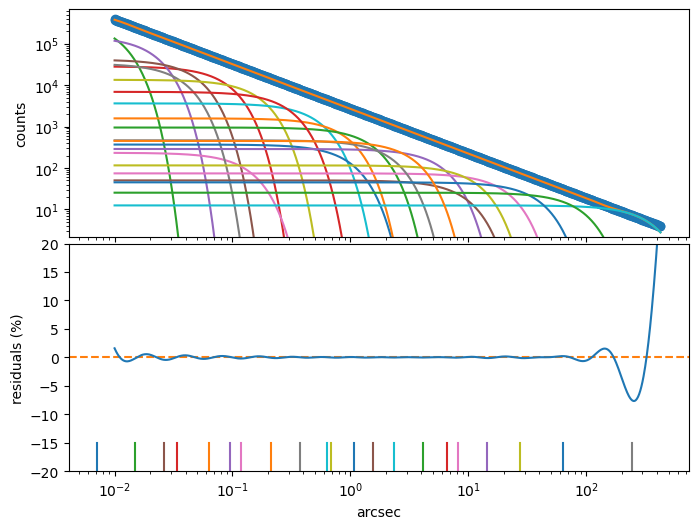

In [7]:
# get total mass profile

total_mass = total_mass_mge(surf_lum, 
                            sigma_lum, 
                            qobs_lum, 
                            'power_law', 
                            qobs_eff, # measured from half-light isophote
                            reff, 
                            break_factor, # radius to which mass is calculated (units of reff)
                            zlens, # lens deflector redshift
                            zsource, # background source redshift
                            cosmo, # cosmology specified above
                            gamma, # power law slope
                            f_dm, # not needed here
                            theta_E, # einstein radius
                            k_mst, # not needed here
                            a_mst, # truncaiton of mass sheet
                            lambda_int, # mass sheet parameter
                            plot=True)

jam_axi_proj(align='cyl', moment='zz') -- elapsed time sec: 0.37
analytic_los=1 logistic=0 constant_anisotropy=1
inc=90.0; beta[1]=0.15; kappa=1.00; M/L=1.09; BH=0.0; chi2/DOF=2.03
Total mass MGE (MSun): 5.560e+13



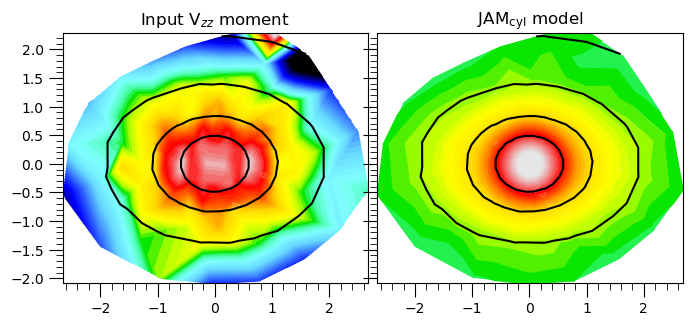

In [8]:
# jam to get velocity

jam_zz = jam_axi_proj(data=Vrms,
                      errors=dVrms,
                      surf_lum=surf_lum, 
                      sigma_lum=sigma_lum, 
                      qobs_lum=qobs_lum,
                      surf_pot=total_mass.surf_pot, 
                      sigma_pot=total_mass.sigma_pot, 
                      qobs_pot=total_mass.qobs_pot,
                      inc=inc, 
                      mbh=mbh, 
                      distance=distance,
                      xbin=xbin.ravel(), 
                      ybin=ybin.ravel(), 
                      align=align,
                      beta=beta, 
                      moment='zz', 
                      pixsize=kcwi_scale,
                      sigmapsf=kcwi_sigmapsf, 
                      normpsf=1., 
                      plot=True,
                      nodots=True)

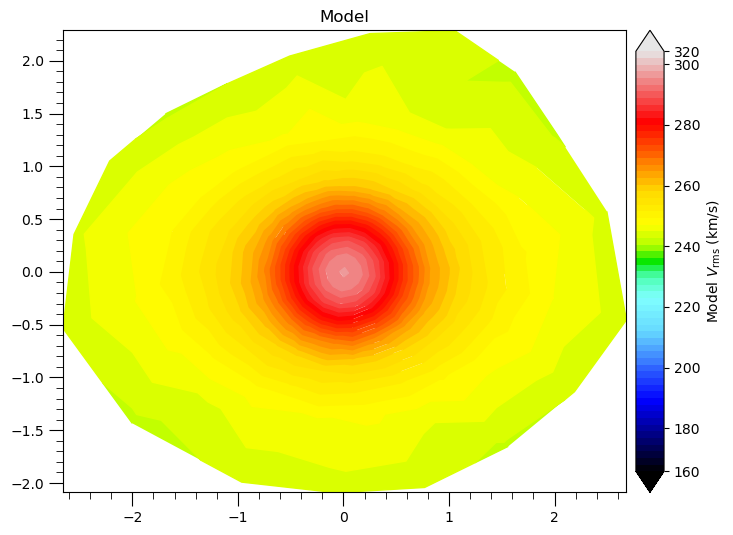

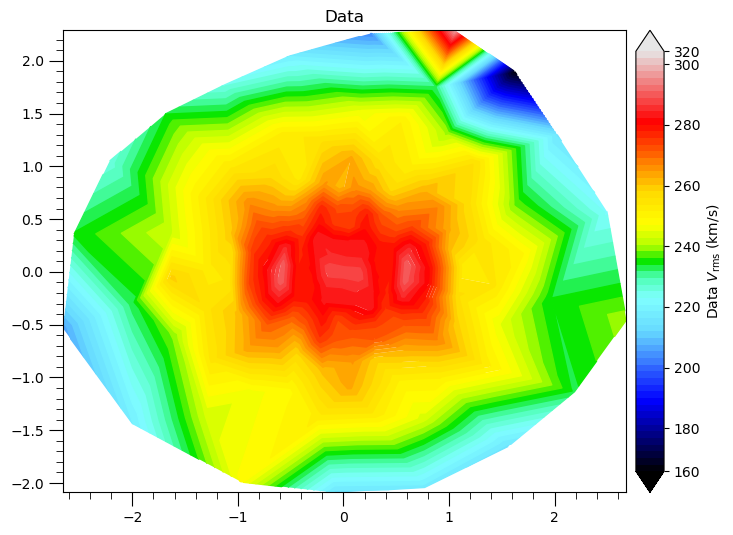

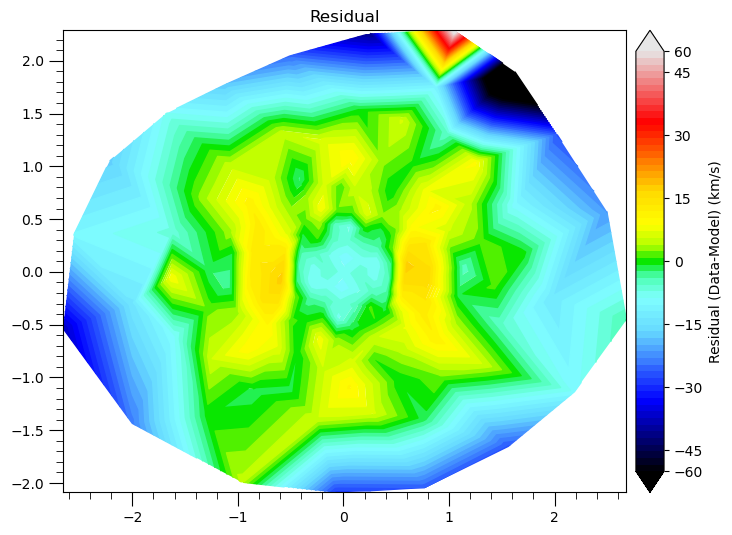

In [9]:
vel_field = jam_zz.model

vmin = np.nanmin((np.nanmin(Vrms), np.nanmin(vel_field)))
vmax = np.nanmax((np.nanmax(Vrms), np.nanmax(vel_field)))

plot_velfield(xbin, ybin, vel_field, vmin=vmin, vmax=vmax, linescolor='w', 
                  colorbar=1, label=r"Model $V_{\rm rms}$ (km/s)", nodots=True) ;
plt.title('Model')
plt.pause(1)

data = symmetrize_velfield(xbin, ybin, Vrms)
plt.figure()
plot_velfield(xbin, ybin, data, vmin=vmin, vmax=vmax, linescolor='w', 
                  colorbar=1, label=r"Data $V_{\rm rms}$ (km/s)", nodots=True) ;
plt.title('Data')
plt.pause(1)

plt.figure()
plot_velfield(xbin, ybin, data-vel_field, vmin=-50, vmax=50, linescolor='w', 
                  colorbar=1, label=r"Residual (Data-Model) (km/s)", nodots=True) ;
plt.title('Residual')
plt.pause(1)

# Now I'm going to do the same thing but doubling the PSF of the data.

jam_axi_proj(align='cyl', moment='zz') -- elapsed time sec: 0.49
analytic_los=1 logistic=0 constant_anisotropy=1
inc=90.0; beta[1]=0.15; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=2.88
Total mass MGE (MSun): 5.112e+13



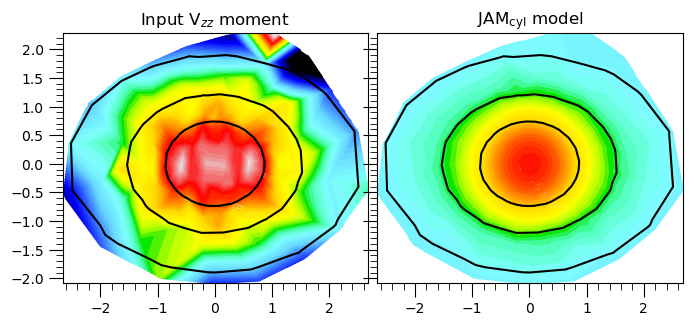

In [10]:
# jam to get velocity

jam_zz = jam_axi_proj(data=Vrms,
                      errors=dVrms,
                      surf_lum=surf_lum, 
                      sigma_lum=sigma_lum, 
                      qobs_lum=qobs_lum,
                      surf_pot=total_mass.surf_pot, 
                      sigma_pot=total_mass.sigma_pot, 
                      qobs_pot=total_mass.qobs_pot,
                      inc=inc, 
                      mbh=mbh, 
                      distance=distance,
                      xbin=xbin.ravel(), 
                      ybin=ybin.ravel(), 
                      align=align,
                      beta=beta, 
                      moment='zz', 
                      pixsize=kcwi_scale,
                      sigmapsf=0.39373654928679985,#kcwi_sigmapsf*2, # ~1.1 arcsec
                      ml=1.,
                      normpsf=1., 
                      plot=True,
                      nodots=True)

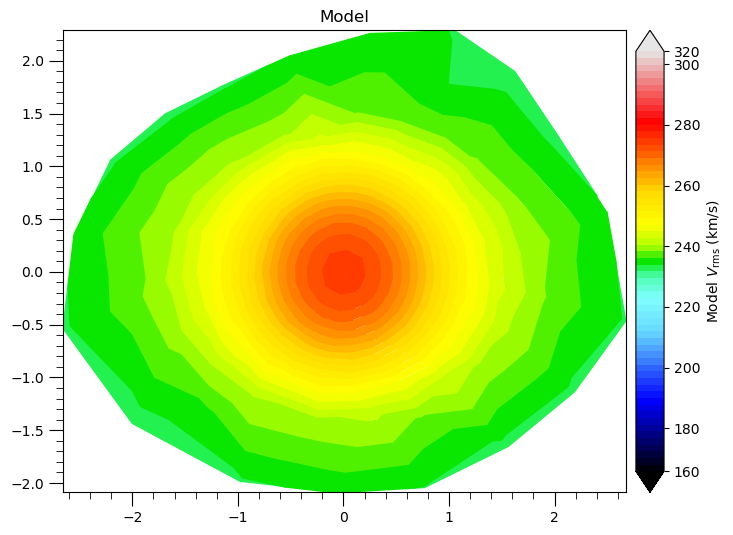

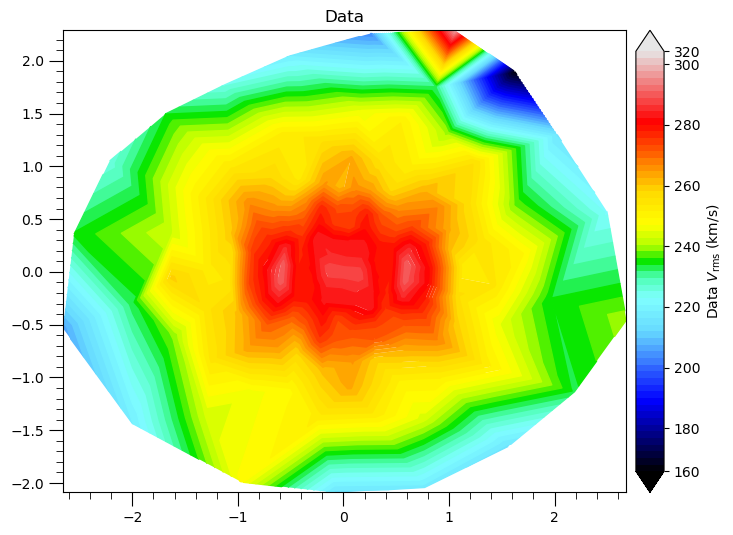

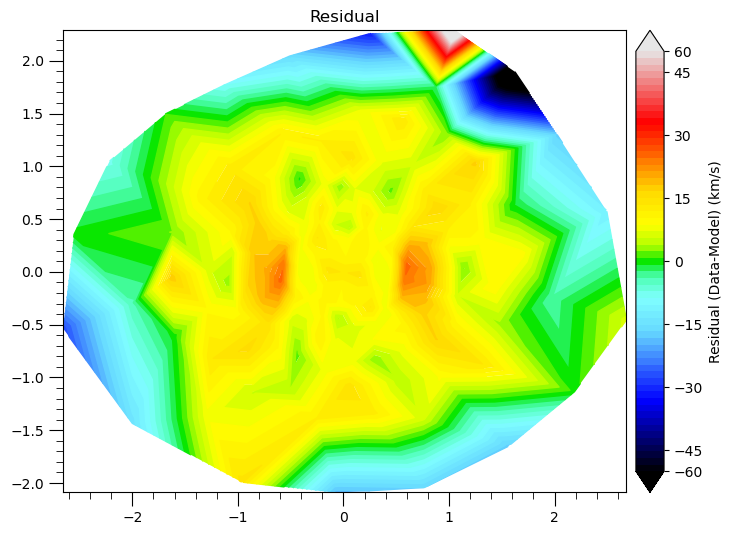

In [11]:
vel_field = jam_zz.model

vmin = np.nanmin((np.nanmin(Vrms), np.nanmin(vel_field)))
vmax = np.nanmax((np.nanmax(Vrms), np.nanmax(vel_field)))

plot_velfield(xbin, ybin, vel_field, vmin=vmin, vmax=vmax, linescolor='w', 
                  colorbar=1, label=r"Model $V_{\rm rms}$ (km/s)", nodots=True) ;
plt.title('Model')
plt.pause(1)

data = symmetrize_velfield(xbin, ybin, Vrms)
plt.figure()
plot_velfield(xbin, ybin, data, vmin=vmin, vmax=vmax, linescolor='w', 
                  colorbar=1, label=r"Data $V_{\rm rms}$ (km/s)", nodots=True) ;
plt.title('Data')
plt.pause(1)

plt.figure()
plot_velfield(xbin, ybin, data-vel_field, vmin=-50, vmax=50, linescolor='w', 
                  colorbar=1, label=r"Residual (Data-Model) (km/s)", nodots=True) ;
plt.title('Residual')
plt.pause(1)

In [12]:
kcwi_sigmapsf

0.2388078047701601

# 01/29/24 - At Michele's suggestion, do a M/L fit.

In [598]:
sigmapsf = 0.393

jam_axi_proj(align='cyl', moment='zz') -- elapsed time sec: 0.29
analytic_los=1 logistic=0 constant_anisotropy=1
inc=90.0; beta[1]=0.15; kappa=1.00; M/L=1.01; BH=0.0; chi2/DOF=1.48
Total mass MGE (MSun): 6.969e+11



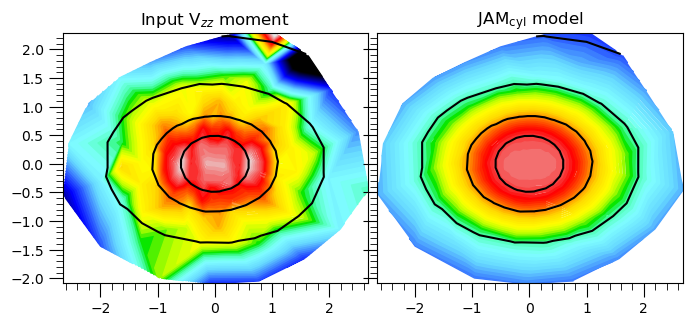

In [599]:
jam_zz = jam_axi_proj(data=Vrms, errors=dVrms, surf_lum=surf_lum, sigma_lum=sigma_lum, qobs_lum=qobs_lum,
                        surf_pot=surf_lum*40, sigma_pot=sigma_lum, qobs_pot=qobs_lum, inc=90, mbh=mbh, distance=distance,
                        xbin=xbin.ravel(), ybin=ybin.ravel(), align='cyl', beta=np.full_like(surf_lum, 0.15),
                        moment='zz', pixsize=kcwi_scale, sigmapsf=kcwi_sigmapsf, normpsf=1., plot=True, nodots=True)

jam_axi_proj(align='cyl', moment='zz') -- elapsed time sec: 0.37
analytic_los=1 logistic=0 constant_anisotropy=1
inc=90.0; beta[1]=0.15; kappa=1.00; M/L=1.09; BH=0.0; chi2/DOF=2.03
Total mass MGE (MSun): 5.560e+13



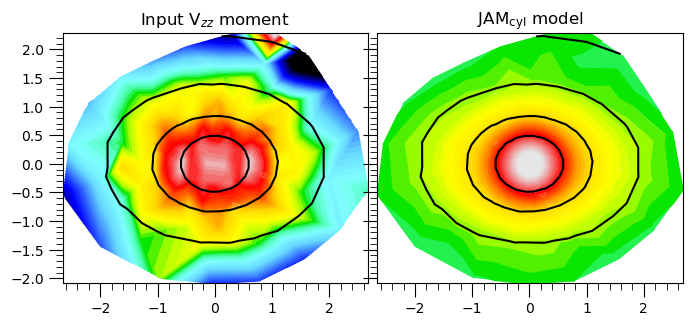

In [14]:
jam_zz = jam_axi_proj(data=Vrms, errors=dVrms, surf_lum=surf_lum, sigma_lum=sigma_lum, qobs_lum=qobs_lum,
                        surf_pot=total_mass.surf_pot, sigma_pot=total_mass.sigma_pot, qobs_pot=total_mass.qobs_pot, 
                      inc=90, mbh=mbh, distance=distance,
                        xbin=xbin.ravel(), ybin=ybin.ravel(), align='cyl', beta=np.full_like(surf_lum, 0.15),
                        moment='zz', pixsize=kcwi_scale, sigmapsf=kcwi_sigmapsf, normpsf=1., plot=True, nodots=True)

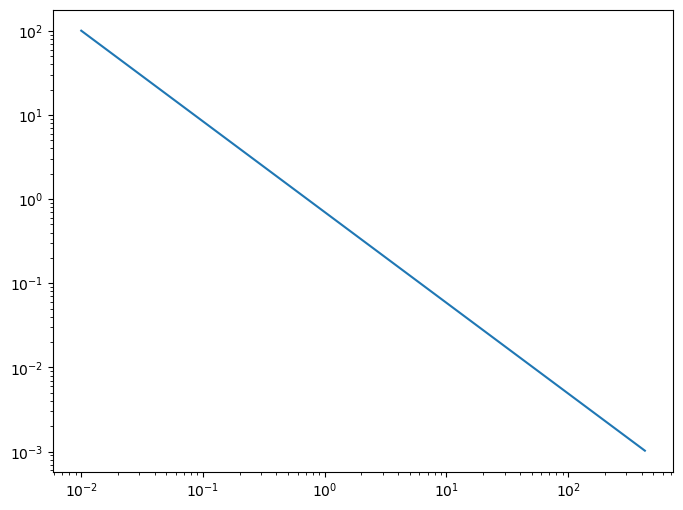

In [15]:
# plot them

plt.loglog(total_mass.r, total_mass.kappa_int)

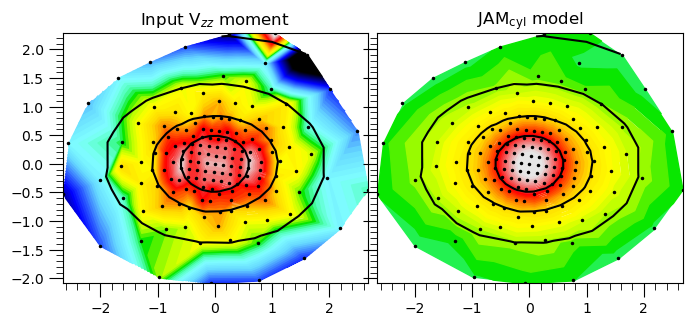

In [16]:
jam_zz.plot()

In [17]:
def calculate_2d_gaussian(xx, yy, amp, sigma, q):
    # take the r**2 from the xx and yy
    r_2 = xx**2 + yy**2 / q**2
    # calculate the gaussian at each point r
    z = amp * np.exp(- 1/2 * r_2 / sigma**2)
    return z

In [18]:
size = 3
xx, yy = np.meshgrid(np.linspace(-size, size, 1000), np.linspace(-size, size, 1000))


In [19]:
amp = total_mass.surf_pot[-1]
sigma = total_mass.sigma_pot[-1]
q = total_mass.qobs_pot[-1]

In [20]:
mass_profile = np.zeros_like(xx, dtype=float)
for i in range(len(total_mass.surf_pot)):
    amp = total_mass.surf_pot[i]
    sigma = total_mass.sigma_pot[i]
    q = total_mass.qobs_pot[i]
    zz = calculate_2d_gaussian(xx, yy, amp, sigma, q)*0.967
    mass_profile += zz
    
lum_profile = np.zeros_like(xx, dtype=float)
for i in range(len(surf_lum)):
    amp = surf_lum[i]
    sigma = sigma_lum[i]
    q = qobs_lum[i]
    zz = calculate_2d_gaussian(xx, yy, amp, sigma, q)*40.7
    lum_profile += zz

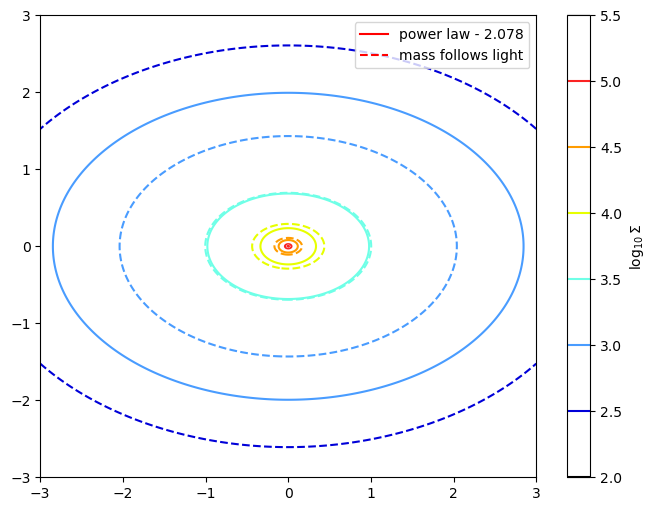

In [21]:
levels = np.arange(2.0, 6.0, 0.5)
plt.figure(figsize=(8,6))
m = plt.contour(xx, yy, np.log10(mass_profile), levels=levels, cmap='sauron', vmin=2.0, vmax=5.5);
l = plt.contour(xx, yy, np.log10(lum_profile), levels=levels, cmap='sauron', vmin=2.0, vmax=5.5,
                linestyles='--');
plt.colorbar(m, label=r'$\log_{10}{\Sigma}}$')
#size=3
plt.xlim(-size, size)
plt.ylim(-size, size)
plt.plot(100, 100, 'r-', label=f'power law - {gamma}')
plt.plot(100, 100, 'r--', label='mass follows light')
plt.legend()


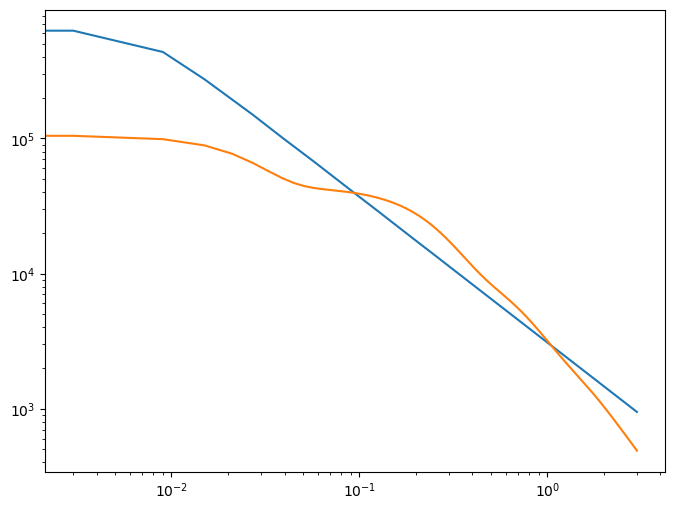

In [22]:
plt.loglog(xx[500], mass_profile[500])
plt.loglog(xx[500], lum_profile[500])

In [23]:
def calculate_1d_gaussian(r, amp, sigma):
    return amp * np.exp(-1/2 * r**2 / sigma**2)

In [24]:
r = total_mass.r
mass_profile_1d = np.zeros_like(r, dtype=float)
for i in range(len(total_mass.surf_pot)):
    amp = total_mass.surf_pot[i]
    sigma = total_mass.sigma_pot[i]
    q = total_mass.qobs_pot[i]
    zz = calculate_1d_gaussian(r, amp, sigma)
    mass_profile_1d += zz
    
lum_profile_1d = np.zeros_like(r, dtype=float)
for i in range(len(surf_lum)):
    amp = surf_lum[i]
    sigma = sigma_lum[i]
    q = qobs_lum[i]
    zz = calculate_1d_gaussian(r, amp, sigma)*40.7
    lum_profile_1d += zz

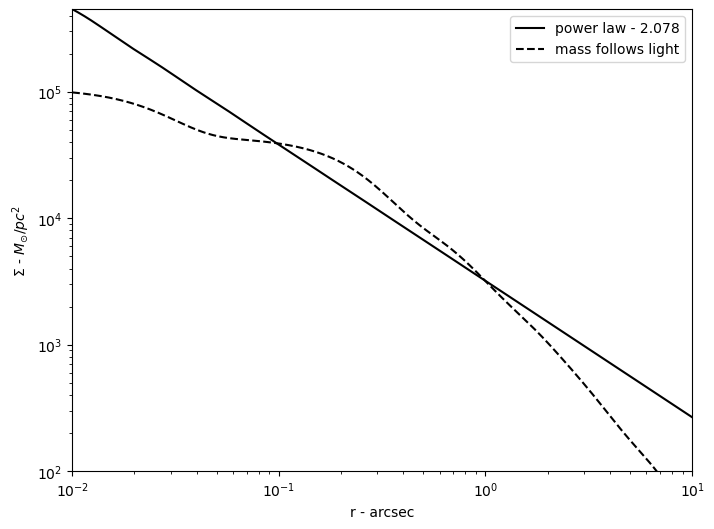

In [25]:
plt.loglog(r, mass_profile_1d, 'k-', label=f'power law - {gamma}');
plt.loglog(r, lum_profile_1d, 'k--', label='mass follows light');
plt.xlim(r.min(), 10)
plt.ylim(10**2, mass_profile_1d.max())
plt.xlabel('r - arcsec')
plt.ylabel(r'$\Sigma$ - $M_{\odot}/pc^2$')
plt.legend()

In [26]:
"{:.2e}".format(np.sum(mass_profile)*(2*size)**2)

'5.25e+10'

# 1/30/24 - Michele's power law code

In [570]:
"""
    Example for Shawn Knabel 
    Michele Cappellari, Oxford, 30 January 2024
"""
import numpy as np

from jampy.jam_axi_proj import jam_axi_proj
from mgefit.mge_fit_1d import mge_fit_1d
from ppxf.capfit import capfit

###############################################################################

def read_data():

    # ppxf model
    Vrms = np.array([290.66167872769785, 295.38618255290766, 293.81853493900996, 287.93280090048444, 278.2382800158685, 276.73082911663283, 285.8153503328707, 284.095788465028, 277.5439254370509,
                    271.8066913888326, 285.8153503328707, 271.72955494038274, 284.095788465028, 271.7689001222741, 271.72955494038274, 277.5439254370509, 279.86336429088294, 284.5941098931966,
                    263.6234638738616, 280.351269956394, 279.86336429088294, 260.90567461637966, 271.0884726987021, 271.0884726987021, 283.9997502884992, 261.29138194982295, 286.9222161527689,
                    259.9284879514581, 276.9138384499886, 249.9135204256946, 283.4350314849977, 271.77323662176366, 273.9757939079413, 273.9757939079413, 269.69526815851833, 269.64048547319237,
                    274.2133445668839, 281.0567735852068, 285.97813437966965, 245.00689431955746, 253.36744537909232, 249.25716038532138, 282.8683975551439, 263.99910321067443, 266.2924153359452,
                    231.28402346802258, 254.14959800837212, 243.6961338581935, 225.91032279246596, 243.18526368258816, 245.12036284560946, 250.1290889293661, 252.43899087532995, 191.93577829124584,
                    200.29258384369592, 249.4682224561548, 253.27347628498111, 239.80008799673269, 252.5456683206909, 247.14001234185727, 259.4245543208898, 287.0488646801372, 272.7236069152104,
                    283.84052944592537, 215.64786103395838, 203.22230586301595, 251.1159343896652, 271.7655892533431, 279.7201691278813, 250.73540082195353, 271.68575507181015, 276.759559620417,
                    277.06689861701653, 261.6799818824849, 285.250504670814, 239.54772893712814, 260.3545053083187, 275.95617063657596, 267.97184994610416, 285.80802336193415, 214.69824058940387,
                    257.30099947582505, 267.8546209314546, 232.70764042468878, 277.05973059863953, 287.5049575578462, 213.97633741290218, 267.29084286498124, 276.48708414352, 283.99152673666146,
                    265.74321283779716, 278.5186830706096, 268.66656615078097, 273.9407183645941, 273.9407183645941, 286.7141163712115, 259.79479453074106, 290.1037161600322, 165.826981627233,
                    276.8363705439413, 295.33294142915133, 262.048464392967, 251.30022850722906, 304.25108535388136, 249.33467697031833, 264.26372816207294, 285.5865095172488, 302.2531426876195,
                    281.75563302754205, 285.5865095172488, 280.91341586241674, 251.38039259114882, 282.2589428877815, 273.2536033014912, 284.83982419865885, 230.65146695481457, 246.5059011223815,
                    273.2837078145517, 270.4107576547776, 228.47946061776494, 301.1082608150456, 292.916371261391, 291.69564960066606, 290.95532348979856, 282.0639926623699, 246.18898510096312,
                    268.6784077457741, 265.8490377135713, 244.2012719553219, 279.97105820993755, 266.2441783323682, 276.6573265702816, 255.61742838447358, 203.27079050880633, 255.9862371199947,
                    268.1315563122035, 244.8820009553631, 280.77827888450224, 287.51861708979857, 296.6140411179058, 273.6933512914125, 284.3134473396941, 262.512731454201, 237.40267785810371,
                    256.6219224884602, 272.40370139996946, 276.49584006274574, 251.9647379845107, 236.9541777067893, 271.50972751698083, 269.3943761990316, 238.69243577831506, 257.13482650352313,
                    278.77901741745904, 243.71949445066986, 254.14798408477682, 230.49714416970957, 270.0694149387297, 257.5367199726272, 270.1223623132098, 212.22210012498692, 218.33700345917808,
                    205.9252814226563, 249.5445313410441, 206.10415348230615])
    dVrms = np.array([6.674197562790939, 6.7913561726457585, 5.86312006255938, 5.652190967315639, 6.055537163769341, 7.0675758736878285, 7.905777995672915, 8.111912648540942, 7.346798790696229,
                    6.542724224711029, 7.905777995672915, 8.201336207508383, 8.111912648540939, 7.77499665138246, 8.201336207508383, 7.34679879069623, 9.594337272694867, 7.693461178307138,
                    7.6027896188189485, 9.759204509446644, 9.594337272694867, 9.008886439446208, 7.057750046934372, 7.057750046934372, 5.91772627011499, 8.61720061038877, 10.00535293715662,
                    9.193454381437974, 10.03047219584612, 9.185908696412966, 9.79914250605688, 10.945381729833183, 8.775092935472976, 8.775092935472976, 14.698406712490218, 9.98607217028801,
                    12.685193371904974, 7.337008725958145, 9.141173358538566, 12.024297026934917, 10.647785294818611, 8.15883020162448, 8.809627240156543, 14.791267408885107, 12.795350827979826,
                    13.862924843453111, 11.85955519978549, 12.430102332022097, 16.147170452237773, 11.020170161819493, 9.853162277697168, 12.050788182132367, 17.555111907182248, 18.390867525936592,
                    14.968242161511826, 15.04205604359545, 14.346865646262371, 19.58930506938615, 13.643048614843549, 12.470041503822186, 8.365879594717029, 9.3180773316227, 10.460767852166597,
                    7.200515744052298, 13.913511995801006, 10.293148974577246, 15.53383312890857, 6.378841249130559, 9.953507642534444, 9.015677268339914, 9.328472584888141, 5.779372367826092,
                    8.654030679296808, 7.916515291103325, 5.421289061571298, 9.82039589236301, 14.904860999205946, 8.209761108412067, 7.763433772922277, 5.364364402813981, 18.04124646244211,
                    9.766819267882347, 7.4047223476870325, 12.141261536638051, 7.869144286633005, 6.9172146673329555, 14.5057795811095, 11.573453560354151, 7.477873524376849, 5.649881391381995,
                    12.163429580945545, 8.119506621180493, 11.93662365335685, 7.529226673378374, 7.529226673378374, 6.161404136681095, 9.937799025807148, 7.220855366226259, 22.456604736022012,
                    7.716421243574321, 5.969032344908219, 19.723245228737657, 10.755314337547437, 9.157813397077618, 11.211198871314545, 11.694225808996615, 8.792093407779301, 8.709640255643032,
                    6.752278073127065, 8.792093407779301, 7.851951731533611, 10.732853680390923, 6.302624006503975, 12.553274210831416, 9.063033100787363, 27.422275536319564, 12.43491009500541,
                    7.929778168614031, 11.194434882229395, 14.036391411055163, 10.487396557714417, 8.00729608430036, 8.914119829880226, 9.25260118009331, 7.069545331599199, 11.209331606022811,
                    9.219212326176224, 11.505625606852135, 10.325479510082136, 8.41579540255715, 8.598181069242363, 9.658890942891446, 10.400243374007317, 22.0624797193553, 11.633375624484648,
                    13.738100165666548, 18.754077173832048, 10.854350668673568, 10.551186955517409, 54.983011956680514, 13.274733726826794, 12.179918722700299, 14.21780691961903, 11.881163080134757,
                    15.034444150772252, 10.304109067715371, 10.383731971259477, 11.026126993439332, 17.74425543998621, 11.727524085688529, 17.562244693019434, 19.599632993126225, 12.864432369296336,
                    12.218176019232555, 13.630050421593666, 21.00593297534936, 9.236846016682277, 21.555481703042062, 15.237538572802315, 13.57612495079024, 14.00976052285976, 19.602167994319096,
                    14.462865777813201, 18.520595168615824, 19.11619071928309]) 
    xbin = np.array([0.019107728101675166, 0.1635493589661612, 0.14444163086448605, 0.0, 0.2888832617289721, 0.30799098983064727, 0.1253339027628109, 0.26977553362729695, -0.019107728101675166,
                    0.4333248925934582, 0.10622617466113572, 0.41421716449178303, 0.2506678055256218, 0.45243262069513335, 0.39510943639010787, -0.03821545620335033, 0.5586587953562691,
                    0.5777665234579442, 0.3037808928561896, 0.07756458250862297, 0.5395510672545939, -0.057323184305025504, -0.1635493589661612, -0.1826570870678364, -0.14444163086448605,
                    0.28467316475451443, 0.5926641545851618, -0.08598477645753824, -0.20176481516951156, 0.2832697990963619, 0.564002562432649, 0.08431171524315545, 0.756213513551323, 0.7753212416529982,
                    0.5257871062292987, -0.2304264073220243, 0.8719935522632963, 0.7944289697546734, 0.5968742515596194, 0.9168887173121216, 1.0628011377238178, 1.0737583674328077, 0.8135366978563485,
                    0.26517688529871675, 0.05246550174036352, 0.7476043745854207, -0.1964210480931316, 1.3146956946557182, 1.555854538599101, 1.4784216678737534, 1.13286280742996, 1.4231710737126335,
                    2.183619146591626, 0.7635672819724029, -0.0735772233404243, -0.25692885374843627, 1.964954834464684, 2.6754403827038447, 1.6837812946432158, 1.3033427553599406, 1.0075289046671492,
                    0.7699774745766181, 0.9848586651812207, 0.6159819796612945, 2.489817338463214, 1.622788394869032, 1.188404736042859, 0.4715403487968085, 0.6446435718138073, 0.8899676102630492,
                    0.49064807689848366, 0.3270987179323224, 0.34620644603399764, 0.5193096690509964, 0.1826570870678364, 0.7646337075002383, 1.2462137173548282, 0.3653141741356728, 0.20176481516951156,
                    0.03821545620335033, 2.0185820414160385, 0.44530759792662683, 0.22087254327118672, 0.6488536687882649, 0.057323184305025504, -0.1253339027628109, 0.9754665897136438,
                    0.24953413542369948, 0.07643091240670066, -0.10622617466113572, 0.35997040705929284, -0.08711844655946055, 0.10509250455921343, -0.30799098983064727, -0.3270987179323224,
                    -0.2888832617289721, -0.3557603100848352, -0.26977553362729695, 1.618780349202816, -0.06801071845778539, -0.2506678055256218, 0.5473234497166964, -0.039349126305272625,
                    -0.2315600774239466, -0.44530759792662683, 0.07108714533032072, -0.45243262069513335, -0.21245234932227144, -0.4333248925934582, -0.4715403487968085, -0.41421716449178303,
                    -0.5002019409493212, -0.39510943639010787, -0.18379075716975868, -0.3760017082884327, 0.8695372670424646, 0.14476526553196234, -0.34734011613592, -0.6315271963787165,
                    -0.5139659019746164, -0.5968742515596194, -0.5777665234579442, -0.6255358437121321, -0.5586587953562691, -0.5395510672545939, -0.21310016080908423, -0.5108894751020812,
                    -0.7264182512968879, -0.42134218726028966, -0.7317620183732678, -0.6935465621699175, -0.7699774745766181, -0.6553311059665672, 0.24743835445928475, -0.5827491674412537,
                    -0.6893364651954599, -0.5143907274565638, -0.8570959211360788, -0.8188804649327285, 1.051696959703871, -0.8953113773394291, -0.8928825360570982, -0.9196979558308379,
                    -1.0057476489750226, -0.855735517013772, -1.0528693836390062, -1.0755396231249346, -1.0910848398423565, -1.1296938683302529, -1.0706229253905941, -1.2946309107039948,
                    -0.9689329657469647, -1.2829719981659282, -1.3467401613059329, -1.254666499024215, -1.2984049807161744, -1.6186068327018917, -1.6917786493390055, -1.6029015757048724,
                    -1.638876304008379, -2.2196097997712236, -2.005307159141188, -2.0016638972176914, -2.5573617478577644, -2.662071494765532]) 
    ybin = np.array([0.14444163086448605, 0.1253339027628109, -0.019107728101675166, 0.0, -0.03821545620335033, 0.10622617466113572, -0.1635493589661612, -0.1826570870678364, -0.14444163086448605,
                    -0.057323184305025504, -0.30799098983064727, -0.20176481516951156, -0.3270987179323224, 0.08711844655946055, -0.34620644603399764, -0.2888832617289721, -0.22087254327118672,
                    -0.07643091240670066, -0.4810942128476461, -0.5246534361273764, -0.3653141741356728, -0.4333248925934582, -0.1253339027628109, -0.26977553362729695, 0.019107728101675166,
                    -0.6255358437121321, -0.5193096690509964, -0.6499873388901872, -0.41421716449178303, -0.8213093062150594, -0.7359721153477254, -0.8439795457009879, -0.39397576628818554,
                    -0.24953413542369948, -1.0248553770766977, -0.6308796107885121, -0.6297459406865897, -0.10509250455921343, 0.06801071845778539, -0.9847371440532913, -0.48352305412997715,
                    -0.21552877619480676, 0.039349126305272625, -1.3284095359125028, -1.084715597141798, -1.3848798813748624, -0.9293167365683218, -0.8686810647120471, -1.648169281618198,
                    -0.48951440679656133, 0.04609625903980513, -0.12947908305062222, -1.1302635203132758, -2.0375469895173564, -2.0875587899901102, -1.3867152343058609, -0.24264717233870534,
                    -0.45071025792486036, 0.17407507578518297, 0.29788675709194895, 0.20964561800596643, 0.26556543665283927, 0.4086037018591729, 0.21245234932227144, 0.5789003833130175,
                    0.6445317633748553, 0.6511210089921096, 0.2315600774239466, 0.42911479561900057, 0.6171156497632169, 0.3760017082884327, 0.2506678055256218, 0.39510943639010787, 0.5926641545851618,
                    0.26977553362729695, 0.7806650087293782, 1.0376186677604278, 0.5395510672545939, 0.41421716449178303, 0.2888832617289721, 1.3064045216252245, 0.7739178759948456, 0.5586587953562691,
                    1.0164351831277822, 0.4333248925934582, 0.1635493589661612, 1.313930222478544, 0.7753212416529982, 0.5777665234579442, 0.30799098983064727, 1.0546506393311326, 0.45243262069513335,
                    0.7944289697546734, -0.10622617466113572, -0.2506678055256218, 0.03821545620335033, -0.4673302518223509, 0.1826570870678364, 1.9013243070732302, 0.5968742515596194,
                    0.3270987179323224, 1.4392808635020742, 0.8135366978563485, 0.4715403487968085, -0.7739178759948456, 1.092866095534483, -0.08711844655946055, 0.6159819796612945,
                    0.057323184305025504, -0.2315600774239466, 0.20176481516951156, -0.4482225237206757, 0.34620644603399764, 0.8326444259580237, 0.49064807689848366, 1.7588306384149384,
                    1.5387243784042222, 0.7073105231952127, -0.70029369490445, -1.1077637266617004, -0.06801071845778539, 0.07643091240670066, -0.28467316475451443, 0.22087254327118672,
                    0.3653141741356728, 1.245936242281478, 0.5819766204324018, -0.491781747000406, 0.8885642446048966, 0.023317825076132795, 0.31220108680510494, -0.26556543665283927, 0.601084348534077,
                    2.2625823154783, 1.3206767059927464, 0.8995214743138868, 2.0495991559921967, 0.18686718404229402, 0.47575044577126613, 2.289367571576068, -0.10201607768667809, 0.6570041671809501,
                    -0.7307581816446381, -0.3813454753648126, -1.1360367674600909, 0.18827054970044657, 0.38722863355365306, -0.10061271202852556, 1.7766041026580797, 0.9967236276798066,
                    -0.34313001916146224, -1.9869032983004256, 0.02275099002517167, 0.7072456065085664, -0.8187186475989904, -1.3544580834338291, 0.38208534728558063, 1.5009128813715633,
                    -0.6029689526493347, -0.04447703151825114, 1.055545142692779, -1.4301204587874783, -0.291590091486036, 0.3603507252318653, -0.5296589441210089])

    surf_lum = np.array([1.54667733e+03, 7.83433919e+02, 2.07231053e+02, 5.46425562e+01, 9.57775068e+00, 2.25260588e+01, 9.44244427e-01, 5.58784186e+00])
    sigma_lum = np.array([0.019, 0.17263495, 0.44429425, 0.88570849, 1.27591855, 1.82680242, 4.7872358 , 4.7872358 ])
    qobs_lum = np.array([0.6691379198652363, 0.65, 0.6882758397304725, 0.691467224803526, 0.85, 0.65, 0.65, 0.85])

    return xbin, ybin, Vrms, dVrms, surf_lum, sigma_lum, qobs_lum

###############################################################################

def total_mass_mge_cap(gamma, rbreak):
    """
    Returns the MGE parameters for a generalized NFW dark halo profile
    https://ui.adsabs.harvard.edu/abs/2001ApJ...555..504W
    - gamma is the inner logarithmic slope (gamma = -1 for NFW)
    - rbreak is the break radius in arcsec

    """
    # The fit is performed in log spaced radii from 0.01" to 10*rbreak
    n = 1000#300     # Number of values to sample the gNFW profile for the MGE fit
    r = np.geomspace(0.01, rbreak*10, n)   # logarithmically spaced radii in arcsec
    #r = np.geomspace(0.01, rbreak, n)   # logarithmically spaced radii in arcsec
    rho = (r/rbreak)**gamma * (0.5 + 0.5*r/rbreak)**(-gamma - 3)  # rho=1 at r=rbreak
    ngauss=30#15
    m = mge_fit_1d(r, rho, ngauss=ngauss, inner_slope=2, outer_slope=3, quiet=1, plot=1)

    surf_dm, sigma_dm = m.sol           # Peak surface density and sigma
    #surf_dm /= np.sqrt(2*np.pi*sigma_dm**2)
    qobs_dm = np.ones_like(surf_dm)     # Assume spherical dark halo

    return surf_dm, sigma_dm, qobs_dm

###############################################################################

def jam_resid(pars, surf_lum=None, sigma_lum=None, qobs_lum=None, distance=None,
              xbin=None, ybin=None, sigmapsf=None, normpsf=None, goodbins=None,
              rms=None, erms=None, pixsize=None, plot=True):

    q, ratio, gamma = pars

    # Sample inclination using min(q), with Equation (14) of Cappellari (2008)
    qmin = np.min(qobs_lum)
    inc = np.degrees(np.arctan2(np.sqrt(1 - qmin**2), np.sqrt(qmin**2 - q**2)))
    beta = np.full_like(qobs_lum, 1 - ratio**2)   # assume constant anisotropy

    rbreak = 20e3              # Adopt fixed halo break radius of 20 kpc (much larger than the data)
    pc = distance*np.pi/0.648   # Constant factor to convert arcsec --> pc
    rbreak /= pc
    # Convert the break radius from pc --> arcsec
    #rbreak = 200*reff
    mbh = 0                     # Ignore the central black hole
    surf_pot, sigma_pot, qobs_pot = total_mass_mge_cap(gamma, rbreak)

    jam = jam_axi_proj(surf_lum, sigma_lum, qobs_lum, surf_pot, sigma_pot, qobs_pot,
                       inc, mbh, distance, xbin, ybin, plot=plot, pixsize=pixsize, quiet=1,
                       sigmapsf=sigmapsf, normpsf=normpsf, goodbins=goodbins, align='cyl',
                       beta=beta, data=rms, errors=erms, ml=None)

    resid = (rms[goodbins] - jam.model[goodbins])/erms[goodbins]

    return resid   # ln(likelihood) + cost.

##############################################################################

def jam_power_law_capfit():

    # SLACS 011924, Email from Shawn Knabel 29 January 2024

    xbin, ybin, rms, erms, surf_lum, sigma_lum, qobs_lum = read_data()

    # Starting guesses
    q0 = np.median(qobs_lum)
    ratio0 = 1          # Anisotropy ratio sigma_z/sigma_R
    gamma0 = -2         # Total mass logarithmic slope rho = r^gamma

    distance =  672.4  # angular size distance at z = 0.195
    pixsize = 0.1457    # spaxel size in arcsec (before Voronoi binning)
    #sigmapsf = 0.24     # kcwi sigma PSF in arcsec
    sigmapsf = 0.39
    normpsf = 1

    qmin = np.min(qobs_lum)
    p0 = [q0, ratio0, gamma0]
    bounds = [[0.051, 0.5, -4], [qmin, 1, 0]]
    goodbins = np.isfinite(xbin)  # Here I fit all bins

    # These parameters are passed to JAM
    kwargs = {'surf_lum': surf_lum, 'sigma_lum': sigma_lum, 'qobs_lum': qobs_lum,
              'distance': distance, 'xbin': xbin, 'ybin': ybin, 'sigmapsf': sigmapsf,
              'normpsf': normpsf, 'rms': rms, 'erms': erms, 'pixsize': pixsize,
              'goodbins': goodbins, 'plot': 0}

    sol = capfit(jam_resid, p0, kwargs=kwargs, bounds=bounds, verbose=2, fixed=[0, 0, 0])

    kwargs['plot'] = 1
    jam_resid(sol.x, **kwargs)
    
    return sol

##############################################################################



Start lambda: 62.63  chi2: 368.4
Start p_free: 0.6500 1.000 -2.000

iter: 1  lambda: 62.63  chi2: 254.1  ratio: 0.9952
p_free: 0.6500 0.9028 -2.060
h: 0.000 -0.09717 -0.05951

iter: 2  lambda: 31.31  chi2: 253.6  ratio: 1.015
p_free: 0.6500 0.9093 -2.057
h: 0.000 0.006458 0.002838

iter: 3  lambda: 15.66  chi2: 253.6  ratio: -1.771
p_free: 0.6500 0.9094 -2.057
h: 0.000 9.602e-05 -3.995e-05

Both ftol and xtol convergence test are satisfied
Final iter: 3  Func calls: 13  chi2: 253.6  Status: 4
Final p: 0.6500 0.9093 -2.057



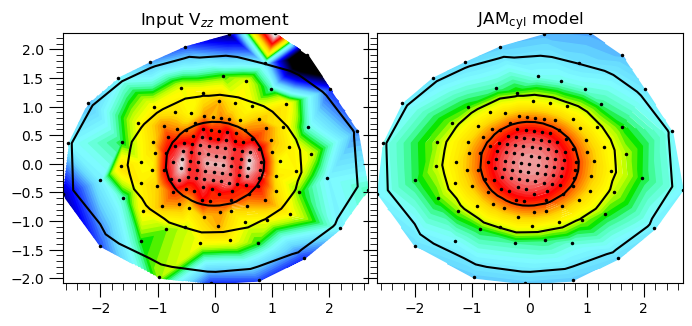

In [571]:

sol = jam_power_law_capfit()


In [591]:
inc = np.degrees(np.arctan2(np.sqrt(1 - qobs_lum.min()**2), np.sqrt(qobs_lum.min()**2 - sol.x[0]**2)))

In [592]:
inc

90.0

In [593]:
# inclination is 90 degrees

In [594]:
sol.x

array([ 0.65      ,  0.90929235, -2.05666972])

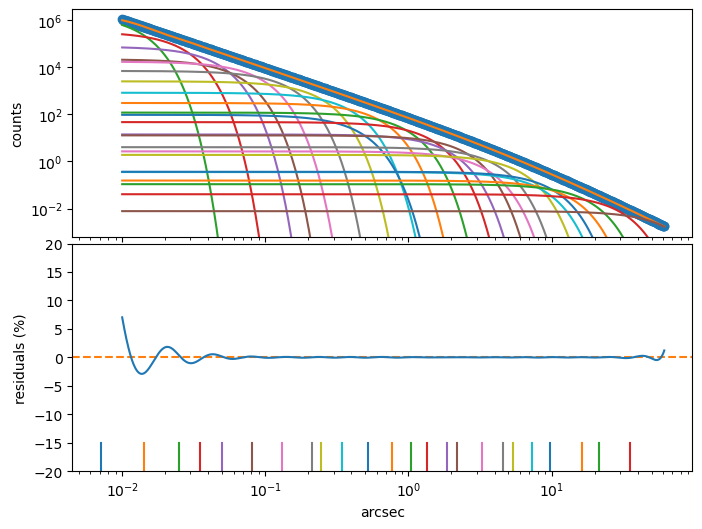

In [595]:
distance =  672.4  # angular size distance at z = 0.195
rbreak = 20e3               # Adopt fixed halo break radius of 20 kpc (much larger than the data)
pc = distance*np.pi/0.648   # Constant factor to convert arcsec --> pc
rbreak /= pc
#rbreak=200*reff

n = 1000     # Number of values to sample the gNFW profile for the MGE fit
r_cap = np.geomspace(0.01, 10*rbreak, n)   # logarithmically spaced radii in arcsec

surf_pot, sigma_pot, qobs_pot = total_mass_mge_cap(sol.x[2], rbreak)



In [596]:
mass_profile_1d_cap = np.zeros_like(r_cap, dtype=float)
for i in range(len(surf_pot)):
    amp = surf_pot[i]/np.sqrt(2*np.pi*sigma_pot[i]**2)
    sigma = sigma_pot[i]
    q = qobs_pot[i]
    zz = calculate_1d_gaussian(r_cap, amp, sigma)
    mass_profile_1d_cap += zz

Text(0, 0.5, '$\\rho$')

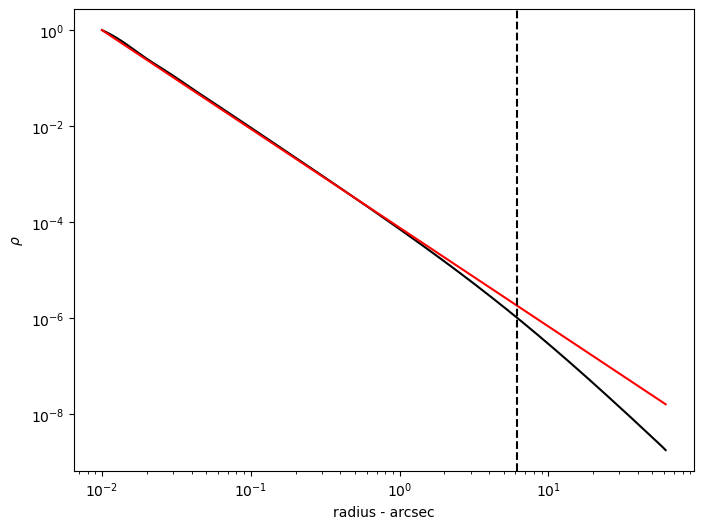

In [597]:
plt.loglog(r_cap, mass_profile_1d_cap/np.max(mass_profile_1d_cap), c='k')
plt.loglog(r_cap, (r_cap**(sol.x[2])/(np.max(r_cap**(sol.x[2])))), c='r')
plt.axvline(rbreak, c='k', linestyle='--')
plt.xlabel('radius - arcsec')
plt.ylabel(r'$\rho$')

# 01/31/24 - This is definitely approximating the power law correctly. How does it look if I rerun the JAM protocol with these bestfit values?

In [119]:
xbin, ybin, Vrms, dVrms, surf_lum_cap, sigma_lum_cap, qobs_lum_cap = read_data()
inc = np.degrees(np.arctan2(np.sqrt(1 - qobs_lum.min()**2), np.sqrt(qobs_lum.min()**2 - sol.x[0]**2)))
print(inc)
mbh=0
anis_ratio = sol.x[1] # 1.4 # ratio of tangential to radial VD
beta = np.ones_like(surf_lum)*(1-anis_ratio**2) # anisotropy
#rbreak = 200*reff
align='cyl'

90.0


In [120]:
beta

array([0.19431423, 0.19431423, 0.19431423, 0.19431423, 0.19431423,
       0.19431423, 0.19431423, 0.19431423])

jam_axi_proj(align='cyl', moment='zz') -- elapsed time sec: 0.49
analytic_los=1 logistic=0 constant_anisotropy=1
inc=90.0; beta[1]=0.19; kappa=1.00; M/L=14.6; BH=0.0; chi2/DOF=1.75
Total mass MGE (MSun): 2.502e+12



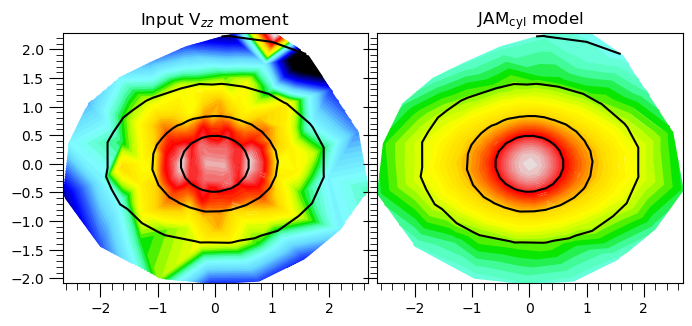

In [121]:
# jam to get velocity

jam_zz = jam_axi_proj(data=Vrms,
                      errors=dVrms,
                      surf_lum=surf_lum_cap, 
                      sigma_lum=sigma_lum_cap, 
                      qobs_lum=qobs_lum_cap,
                      surf_pot=surf_pot,#total_mass.surf_pot, 
                      sigma_pot=sigma_pot,#total_mass.sigma_pot, 
                      qobs_pot=qobs_pot,#np.ones_like(total_mass.surf_pot),#total_mass.qobs_pot,
                      inc=inc, 
                      mbh=mbh, 
                      distance=distance,
                      xbin=xbin, 
                      ybin=ybin, 
                      align=align,
                      beta=beta, 
                      moment='zz', 
                      pixsize=kcwi_scale,
                      sigmapsf=kcwi_sigmapsf, 
                      normpsf=1., 
                      plot=True,
                      nodots=True)

# Redo my plot with this fit (and simplify to the spherical case)

In [122]:
xbin, ybin, Vrms, dVrms, surf_lum, sigma_lum, qobs_lum = read_data()

In [584]:
# Mass
# lens model
gamma = 2.19843055#-sol.x[2]#2.38 # powser law slope
theta_E = 1.3636014 # einstein radius
# choices
f_dm = 0 # not necessary here
k_mst = None # not necessary here
a_mst = 6.81664498 # truncation radius of mass sheet, units of reff
lambda_int = 0.83090403 # internal mass sheet parameter random choice
break_factor = 20 # radius to which mass is calculated (units of reff)

# JAM
inc = 84#np.degrees(np.arctan2(np.sqrt(1 - qobs_lum.min()**2), np.sqrt(qobs_lum.min()**2 - 0.6**2)))#inc=90 # inclination
mbh=0 # black hole mass
distance =  cosmo.angular_diameter_distance(zlens).value # distance to lens in Mpc
anis_ratio = 0.90435441#sol.x[1] # 1.4 # ratio of tangential to radial VD
beta = np.ones_like(surf_lum)*(1-anis_ratio**2) # anisotropy
#beta = np.full_like(qobs_lum, 1 - anis_ratio**2)
align = 'cyl' 


In [585]:
beta

array([0.1821431, 0.1821431, 0.1821431, 0.1821431, 0.1821431, 0.1821431,
       0.1821431, 0.1821431])

Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`


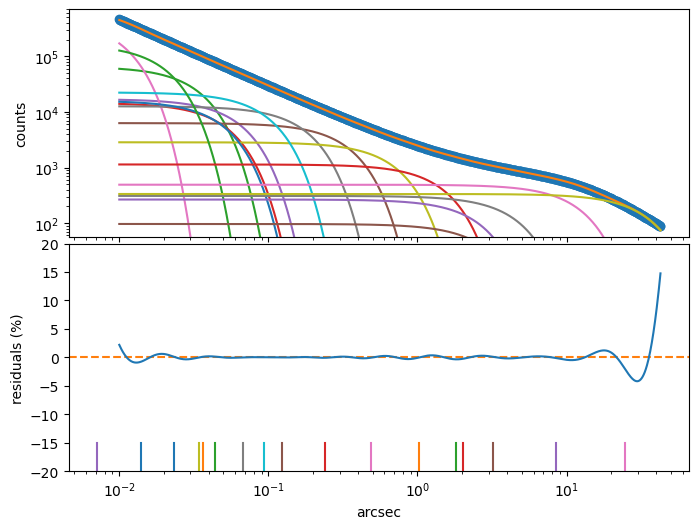

In [586]:
# get total mass profile

total_mass = total_mass_mge(surf_lum, 
                            sigma_lum, 
                            qobs_lum, 
                            'power_law', 
                            qobs_eff, # I'm setting this at 1 because michele's power law was a sphere #qobs_eff, # measured from half-light isophote
                            reff, 
                            break_factor, # radius to which mass is calculated (units of reff)
                            zlens, # lens deflector redshift
                            zsource, # background source redshift
                            cosmo, # cosmology specified above
                            gamma, # power law slope
                            f_dm, # not needed here
                            theta_E, # einstein radius
                            k_mst, # not needed here
                            a_mst, # truncaiton of mass sheet
                            lambda_int, # mass sheet parameter
                            plot=True)

In [587]:
sigma_psf=0.39373654928679985#1.0/2.355

In [588]:
sigma_psf

0.39373654928679985

In [589]:
kcwi_sigmapsf*2.355

0.562392380233727

jam_axi_proj(align='cyl', moment='zz') -- elapsed time sec: 0.44
analytic_los=1 logistic=0 constant_anisotropy=1
inc=84.0; beta[1]=0.18; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=8.05
Total mass MGE (MSun): 1.349e+13



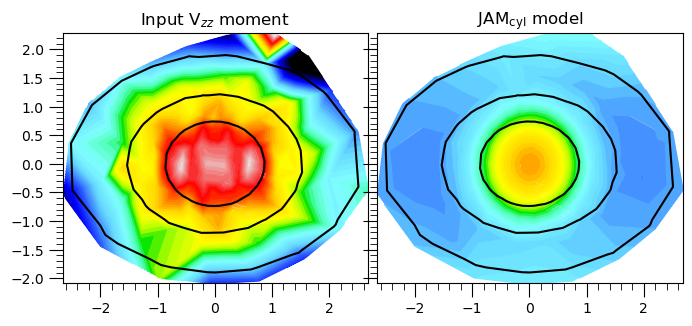

In [590]:
# jam to get velocity

jam_zz = jam_axi_proj(data=Vrms,
                      errors=dVrms,
                      surf_lum=surf_lum, 
                      sigma_lum=sigma_lum, 
                      qobs_lum=qobs_lum,
                      surf_pot=total_mass.surf_pot, 
                      sigma_pot=total_mass.sigma_pot, 
                      qobs_pot=total_mass.qobs_pot,
                      inc=inc, 
                      mbh=mbh, 
                      distance=distance,
                      xbin=xbin, 
                      ybin=ybin, 
                      align='cyl',#align,
                      beta=beta, 
                      moment='zz', 
                      pixsize=kcwi_scale,
                      sigmapsf=sigma_psf,#kcwi_sigmapsf,
                      normpsf=1.,
                      ml=1,
                      plot=True,
                      nodots=True)

In [491]:
r = total_mass.r
mass_profile_1d = np.zeros_like(r, dtype=float)
for i in range(len(total_mass.surf_pot)):
    amp = total_mass.surf_pot[i]/np.sqrt(2*np.pi*total_mass.sigma_pot[i]**2)
    sigma = total_mass.sigma_pot[i]
    q = total_mass.qobs_pot[i]
    zz = calculate_1d_gaussian(r, amp, sigma)
    mass_profile_1d += zz

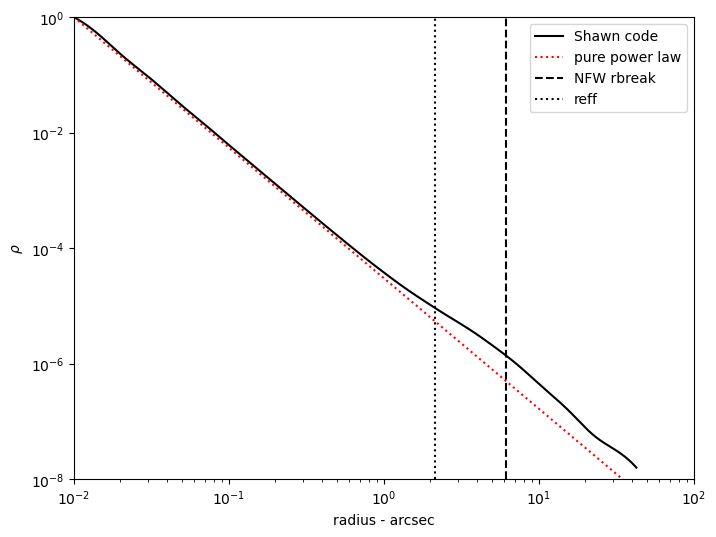

In [435]:
plt.loglog(r, mass_profile_1d/np.nanmax(mass_profile_1d), c='k', label='Shawn code')
plt.loglog(r, r**-gamma/np.nanmax(r**-gamma), c='r', linestyle=':', label='pure power law')
plt.axvline(rbreak, c='k', linestyle='--', label='NFW rbreak')
plt.axvline(reff, c='k', linestyle=':', label='reff')
plt.xlim(10**-2, 10**2)
plt.ylim(1e-8, 1)
plt.xlabel('radius - arcsec')
plt.ylabel(r'$\rho$')
plt.legend()

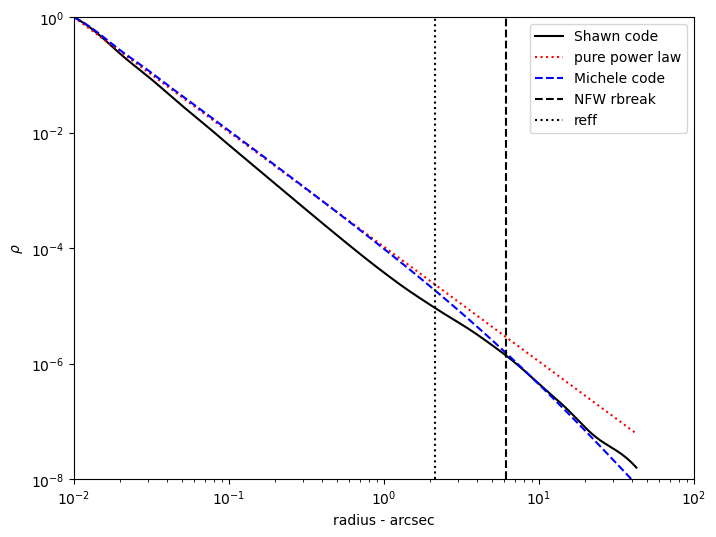

In [436]:
plt.loglog(r, mass_profile_1d/np.nanmax(mass_profile_1d), c='k', label='Shawn code')
plt.loglog(r, r**sol.x[2]/np.nanmax(r**sol.x[2]), c='r', linestyle=':', label='pure power law')
plt.loglog(r_cap, mass_profile_1d_cap/np.max(mass_profile_1d_cap), c='b', linestyle='--', label='Michele code')
plt.axvline(rbreak, c='k', linestyle='--', label='NFW rbreak')
plt.axvline(reff, c='k', linestyle=':', label='reff')
plt.xlim(10**-2, 10**2)
plt.ylim(1e-8, 1)
plt.xlabel('radius - arcsec')
plt.ylabel(r'$\rho$')
plt.legend()

In [47]:
# Try to do a power law in 3D

In [48]:
rbreak_ = 20e3               # Adopt fixed halo break radius of 20 kpc (much larger than the data)
pc = distance*np.pi/0.648   # Constant factor to convert arcsec --> pc
rbreak_ /= pc  
rbreak_

6.18315529779139

# Michele's original code


Start lambda: 122.9  chi2: 439.1
Start p_free: 0.6500 1.000 -2.000

iter: 1  lambda: 122.9  chi2: 291.0  ratio: 0.9932
p_free: 0.6500 0.8887 -1.992
h: 0.000 -0.1113 0.007737

iter: 2  lambda: 61.47  chi2: 288.6  ratio: 0.9961
p_free: 0.6500 0.8976 -1.987
h: 0.000 0.008959 0.005334

iter: 3  lambda: 30.74  chi2: 288.6  ratio: 1.007
p_free: 0.6500 0.8978 -1.987
h: 0.000 0.0002289 -0.0003104

Terminating on small function variation (ftol)
Final iter: 3  Func calls: 13  chi2: 288.6  Status: 2
Final p: 0.6500 0.8978 -1.987



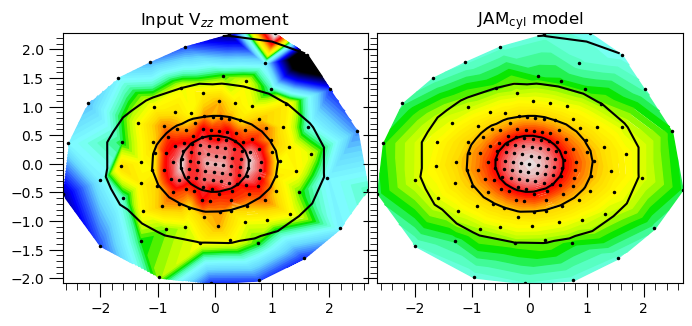

In [55]:
"""
    Example for Shawn Knabel 
    Michele Cappellari, Oxford, 30 January 2024
"""
import numpy as np

from jampy.jam_axi_proj import jam_axi_proj
from mgefit.mge_fit_1d import mge_fit_1d
from ppxf.capfit import capfit

###############################################################################

def read_data():

    # ppxf model
    Vrms = np.array([290.66167872769785, 295.38618255290766, 293.81853493900996, 287.93280090048444, 278.2382800158685, 276.73082911663283, 285.8153503328707, 284.095788465028, 277.5439254370509,
                    271.8066913888326, 285.8153503328707, 271.72955494038274, 284.095788465028, 271.7689001222741, 271.72955494038274, 277.5439254370509, 279.86336429088294, 284.5941098931966,
                    263.6234638738616, 280.351269956394, 279.86336429088294, 260.90567461637966, 271.0884726987021, 271.0884726987021, 283.9997502884992, 261.29138194982295, 286.9222161527689,
                    259.9284879514581, 276.9138384499886, 249.9135204256946, 283.4350314849977, 271.77323662176366, 273.9757939079413, 273.9757939079413, 269.69526815851833, 269.64048547319237,
                    274.2133445668839, 281.0567735852068, 285.97813437966965, 245.00689431955746, 253.36744537909232, 249.25716038532138, 282.8683975551439, 263.99910321067443, 266.2924153359452,
                    231.28402346802258, 254.14959800837212, 243.6961338581935, 225.91032279246596, 243.18526368258816, 245.12036284560946, 250.1290889293661, 252.43899087532995, 191.93577829124584,
                    200.29258384369592, 249.4682224561548, 253.27347628498111, 239.80008799673269, 252.5456683206909, 247.14001234185727, 259.4245543208898, 287.0488646801372, 272.7236069152104,
                    283.84052944592537, 215.64786103395838, 203.22230586301595, 251.1159343896652, 271.7655892533431, 279.7201691278813, 250.73540082195353, 271.68575507181015, 276.759559620417,
                    277.06689861701653, 261.6799818824849, 285.250504670814, 239.54772893712814, 260.3545053083187, 275.95617063657596, 267.97184994610416, 285.80802336193415, 214.69824058940387,
                    257.30099947582505, 267.8546209314546, 232.70764042468878, 277.05973059863953, 287.5049575578462, 213.97633741290218, 267.29084286498124, 276.48708414352, 283.99152673666146,
                    265.74321283779716, 278.5186830706096, 268.66656615078097, 273.9407183645941, 273.9407183645941, 286.7141163712115, 259.79479453074106, 290.1037161600322, 165.826981627233,
                    276.8363705439413, 295.33294142915133, 262.048464392967, 251.30022850722906, 304.25108535388136, 249.33467697031833, 264.26372816207294, 285.5865095172488, 302.2531426876195,
                    281.75563302754205, 285.5865095172488, 280.91341586241674, 251.38039259114882, 282.2589428877815, 273.2536033014912, 284.83982419865885, 230.65146695481457, 246.5059011223815,
                    273.2837078145517, 270.4107576547776, 228.47946061776494, 301.1082608150456, 292.916371261391, 291.69564960066606, 290.95532348979856, 282.0639926623699, 246.18898510096312,
                    268.6784077457741, 265.8490377135713, 244.2012719553219, 279.97105820993755, 266.2441783323682, 276.6573265702816, 255.61742838447358, 203.27079050880633, 255.9862371199947,
                    268.1315563122035, 244.8820009553631, 280.77827888450224, 287.51861708979857, 296.6140411179058, 273.6933512914125, 284.3134473396941, 262.512731454201, 237.40267785810371,
                    256.6219224884602, 272.40370139996946, 276.49584006274574, 251.9647379845107, 236.9541777067893, 271.50972751698083, 269.3943761990316, 238.69243577831506, 257.13482650352313,
                    278.77901741745904, 243.71949445066986, 254.14798408477682, 230.49714416970957, 270.0694149387297, 257.5367199726272, 270.1223623132098, 212.22210012498692, 218.33700345917808,
                    205.9252814226563, 249.5445313410441, 206.10415348230615])
    dVrms = np.array([6.674197562790939, 6.7913561726457585, 5.86312006255938, 5.652190967315639, 6.055537163769341, 7.0675758736878285, 7.905777995672915, 8.111912648540942, 7.346798790696229,
                    6.542724224711029, 7.905777995672915, 8.201336207508383, 8.111912648540939, 7.77499665138246, 8.201336207508383, 7.34679879069623, 9.594337272694867, 7.693461178307138,
                    7.6027896188189485, 9.759204509446644, 9.594337272694867, 9.008886439446208, 7.057750046934372, 7.057750046934372, 5.91772627011499, 8.61720061038877, 10.00535293715662,
                    9.193454381437974, 10.03047219584612, 9.185908696412966, 9.79914250605688, 10.945381729833183, 8.775092935472976, 8.775092935472976, 14.698406712490218, 9.98607217028801,
                    12.685193371904974, 7.337008725958145, 9.141173358538566, 12.024297026934917, 10.647785294818611, 8.15883020162448, 8.809627240156543, 14.791267408885107, 12.795350827979826,
                    13.862924843453111, 11.85955519978549, 12.430102332022097, 16.147170452237773, 11.020170161819493, 9.853162277697168, 12.050788182132367, 17.555111907182248, 18.390867525936592,
                    14.968242161511826, 15.04205604359545, 14.346865646262371, 19.58930506938615, 13.643048614843549, 12.470041503822186, 8.365879594717029, 9.3180773316227, 10.460767852166597,
                    7.200515744052298, 13.913511995801006, 10.293148974577246, 15.53383312890857, 6.378841249130559, 9.953507642534444, 9.015677268339914, 9.328472584888141, 5.779372367826092,
                    8.654030679296808, 7.916515291103325, 5.421289061571298, 9.82039589236301, 14.904860999205946, 8.209761108412067, 7.763433772922277, 5.364364402813981, 18.04124646244211,
                    9.766819267882347, 7.4047223476870325, 12.141261536638051, 7.869144286633005, 6.9172146673329555, 14.5057795811095, 11.573453560354151, 7.477873524376849, 5.649881391381995,
                    12.163429580945545, 8.119506621180493, 11.93662365335685, 7.529226673378374, 7.529226673378374, 6.161404136681095, 9.937799025807148, 7.220855366226259, 22.456604736022012,
                    7.716421243574321, 5.969032344908219, 19.723245228737657, 10.755314337547437, 9.157813397077618, 11.211198871314545, 11.694225808996615, 8.792093407779301, 8.709640255643032,
                    6.752278073127065, 8.792093407779301, 7.851951731533611, 10.732853680390923, 6.302624006503975, 12.553274210831416, 9.063033100787363, 27.422275536319564, 12.43491009500541,
                    7.929778168614031, 11.194434882229395, 14.036391411055163, 10.487396557714417, 8.00729608430036, 8.914119829880226, 9.25260118009331, 7.069545331599199, 11.209331606022811,
                    9.219212326176224, 11.505625606852135, 10.325479510082136, 8.41579540255715, 8.598181069242363, 9.658890942891446, 10.400243374007317, 22.0624797193553, 11.633375624484648,
                    13.738100165666548, 18.754077173832048, 10.854350668673568, 10.551186955517409, 54.983011956680514, 13.274733726826794, 12.179918722700299, 14.21780691961903, 11.881163080134757,
                    15.034444150772252, 10.304109067715371, 10.383731971259477, 11.026126993439332, 17.74425543998621, 11.727524085688529, 17.562244693019434, 19.599632993126225, 12.864432369296336,
                    12.218176019232555, 13.630050421593666, 21.00593297534936, 9.236846016682277, 21.555481703042062, 15.237538572802315, 13.57612495079024, 14.00976052285976, 19.602167994319096,
                    14.462865777813201, 18.520595168615824, 19.11619071928309]) 
    xbin = np.array([0.019107728101675166, 0.1635493589661612, 0.14444163086448605, 0.0, 0.2888832617289721, 0.30799098983064727, 0.1253339027628109, 0.26977553362729695, -0.019107728101675166,
                    0.4333248925934582, 0.10622617466113572, 0.41421716449178303, 0.2506678055256218, 0.45243262069513335, 0.39510943639010787, -0.03821545620335033, 0.5586587953562691,
                    0.5777665234579442, 0.3037808928561896, 0.07756458250862297, 0.5395510672545939, -0.057323184305025504, -0.1635493589661612, -0.1826570870678364, -0.14444163086448605,
                    0.28467316475451443, 0.5926641545851618, -0.08598477645753824, -0.20176481516951156, 0.2832697990963619, 0.564002562432649, 0.08431171524315545, 0.756213513551323, 0.7753212416529982,
                    0.5257871062292987, -0.2304264073220243, 0.8719935522632963, 0.7944289697546734, 0.5968742515596194, 0.9168887173121216, 1.0628011377238178, 1.0737583674328077, 0.8135366978563485,
                    0.26517688529871675, 0.05246550174036352, 0.7476043745854207, -0.1964210480931316, 1.3146956946557182, 1.555854538599101, 1.4784216678737534, 1.13286280742996, 1.4231710737126335,
                    2.183619146591626, 0.7635672819724029, -0.0735772233404243, -0.25692885374843627, 1.964954834464684, 2.6754403827038447, 1.6837812946432158, 1.3033427553599406, 1.0075289046671492,
                    0.7699774745766181, 0.9848586651812207, 0.6159819796612945, 2.489817338463214, 1.622788394869032, 1.188404736042859, 0.4715403487968085, 0.6446435718138073, 0.8899676102630492,
                    0.49064807689848366, 0.3270987179323224, 0.34620644603399764, 0.5193096690509964, 0.1826570870678364, 0.7646337075002383, 1.2462137173548282, 0.3653141741356728, 0.20176481516951156,
                    0.03821545620335033, 2.0185820414160385, 0.44530759792662683, 0.22087254327118672, 0.6488536687882649, 0.057323184305025504, -0.1253339027628109, 0.9754665897136438,
                    0.24953413542369948, 0.07643091240670066, -0.10622617466113572, 0.35997040705929284, -0.08711844655946055, 0.10509250455921343, -0.30799098983064727, -0.3270987179323224,
                    -0.2888832617289721, -0.3557603100848352, -0.26977553362729695, 1.618780349202816, -0.06801071845778539, -0.2506678055256218, 0.5473234497166964, -0.039349126305272625,
                    -0.2315600774239466, -0.44530759792662683, 0.07108714533032072, -0.45243262069513335, -0.21245234932227144, -0.4333248925934582, -0.4715403487968085, -0.41421716449178303,
                    -0.5002019409493212, -0.39510943639010787, -0.18379075716975868, -0.3760017082884327, 0.8695372670424646, 0.14476526553196234, -0.34734011613592, -0.6315271963787165,
                    -0.5139659019746164, -0.5968742515596194, -0.5777665234579442, -0.6255358437121321, -0.5586587953562691, -0.5395510672545939, -0.21310016080908423, -0.5108894751020812,
                    -0.7264182512968879, -0.42134218726028966, -0.7317620183732678, -0.6935465621699175, -0.7699774745766181, -0.6553311059665672, 0.24743835445928475, -0.5827491674412537,
                    -0.6893364651954599, -0.5143907274565638, -0.8570959211360788, -0.8188804649327285, 1.051696959703871, -0.8953113773394291, -0.8928825360570982, -0.9196979558308379,
                    -1.0057476489750226, -0.855735517013772, -1.0528693836390062, -1.0755396231249346, -1.0910848398423565, -1.1296938683302529, -1.0706229253905941, -1.2946309107039948,
                    -0.9689329657469647, -1.2829719981659282, -1.3467401613059329, -1.254666499024215, -1.2984049807161744, -1.6186068327018917, -1.6917786493390055, -1.6029015757048724,
                    -1.638876304008379, -2.2196097997712236, -2.005307159141188, -2.0016638972176914, -2.5573617478577644, -2.662071494765532]) 
    ybin = np.array([0.14444163086448605, 0.1253339027628109, -0.019107728101675166, 0.0, -0.03821545620335033, 0.10622617466113572, -0.1635493589661612, -0.1826570870678364, -0.14444163086448605,
                    -0.057323184305025504, -0.30799098983064727, -0.20176481516951156, -0.3270987179323224, 0.08711844655946055, -0.34620644603399764, -0.2888832617289721, -0.22087254327118672,
                    -0.07643091240670066, -0.4810942128476461, -0.5246534361273764, -0.3653141741356728, -0.4333248925934582, -0.1253339027628109, -0.26977553362729695, 0.019107728101675166,
                    -0.6255358437121321, -0.5193096690509964, -0.6499873388901872, -0.41421716449178303, -0.8213093062150594, -0.7359721153477254, -0.8439795457009879, -0.39397576628818554,
                    -0.24953413542369948, -1.0248553770766977, -0.6308796107885121, -0.6297459406865897, -0.10509250455921343, 0.06801071845778539, -0.9847371440532913, -0.48352305412997715,
                    -0.21552877619480676, 0.039349126305272625, -1.3284095359125028, -1.084715597141798, -1.3848798813748624, -0.9293167365683218, -0.8686810647120471, -1.648169281618198,
                    -0.48951440679656133, 0.04609625903980513, -0.12947908305062222, -1.1302635203132758, -2.0375469895173564, -2.0875587899901102, -1.3867152343058609, -0.24264717233870534,
                    -0.45071025792486036, 0.17407507578518297, 0.29788675709194895, 0.20964561800596643, 0.26556543665283927, 0.4086037018591729, 0.21245234932227144, 0.5789003833130175,
                    0.6445317633748553, 0.6511210089921096, 0.2315600774239466, 0.42911479561900057, 0.6171156497632169, 0.3760017082884327, 0.2506678055256218, 0.39510943639010787, 0.5926641545851618,
                    0.26977553362729695, 0.7806650087293782, 1.0376186677604278, 0.5395510672545939, 0.41421716449178303, 0.2888832617289721, 1.3064045216252245, 0.7739178759948456, 0.5586587953562691,
                    1.0164351831277822, 0.4333248925934582, 0.1635493589661612, 1.313930222478544, 0.7753212416529982, 0.5777665234579442, 0.30799098983064727, 1.0546506393311326, 0.45243262069513335,
                    0.7944289697546734, -0.10622617466113572, -0.2506678055256218, 0.03821545620335033, -0.4673302518223509, 0.1826570870678364, 1.9013243070732302, 0.5968742515596194,
                    0.3270987179323224, 1.4392808635020742, 0.8135366978563485, 0.4715403487968085, -0.7739178759948456, 1.092866095534483, -0.08711844655946055, 0.6159819796612945,
                    0.057323184305025504, -0.2315600774239466, 0.20176481516951156, -0.4482225237206757, 0.34620644603399764, 0.8326444259580237, 0.49064807689848366, 1.7588306384149384,
                    1.5387243784042222, 0.7073105231952127, -0.70029369490445, -1.1077637266617004, -0.06801071845778539, 0.07643091240670066, -0.28467316475451443, 0.22087254327118672,
                    0.3653141741356728, 1.245936242281478, 0.5819766204324018, -0.491781747000406, 0.8885642446048966, 0.023317825076132795, 0.31220108680510494, -0.26556543665283927, 0.601084348534077,
                    2.2625823154783, 1.3206767059927464, 0.8995214743138868, 2.0495991559921967, 0.18686718404229402, 0.47575044577126613, 2.289367571576068, -0.10201607768667809, 0.6570041671809501,
                    -0.7307581816446381, -0.3813454753648126, -1.1360367674600909, 0.18827054970044657, 0.38722863355365306, -0.10061271202852556, 1.7766041026580797, 0.9967236276798066,
                    -0.34313001916146224, -1.9869032983004256, 0.02275099002517167, 0.7072456065085664, -0.8187186475989904, -1.3544580834338291, 0.38208534728558063, 1.5009128813715633,
                    -0.6029689526493347, -0.04447703151825114, 1.055545142692779, -1.4301204587874783, -0.291590091486036, 0.3603507252318653, -0.5296589441210089])

    surf_lum = np.array([1.54667733e+03, 7.83433919e+02, 2.07231053e+02, 5.46425562e+01, 9.57775068e+00, 2.25260588e+01, 9.44244427e-01, 5.58784186e+00])
    sigma_lum = np.array([0.019, 0.17263495, 0.44429425, 0.88570849, 1.27591855, 1.82680242, 4.7872358 , 4.7872358 ])
    qobs_lum = np.array([0.6691379198652363, 0.65, 0.6882758397304725, 0.691467224803526, 0.85, 0.65, 0.65, 0.85])

    return xbin, ybin, Vrms, dVrms, surf_lum, sigma_lum, qobs_lum

###############################################################################

def total_mass_mge(gamma, rbreak):
    """
    Returns the MGE parameters for a generalized NFW dark halo profile
    https://ui.adsabs.harvard.edu/abs/2001ApJ...555..504W
    - gamma is the inner logarithmic slope (gamma = -1 for NFW)
    - rbreak is the break radius in arcsec

    """
    # The fit is performed in log spaced radii from 0.01" to 10*rbreak
    n = 1000#300     # Number of values to sample the gNFW profile for the MGE fit
    r = np.geomspace(0.01, rbreak*10, n)   # logarithmically spaced radii in arcsec
    rho = (r/rbreak)**gamma * (0.5 + 0.5*r/rbreak)**(-gamma - 3)  # rho=1 at r=rbreak
    m = mge_fit_1d(r, rho, ngauss=15, quiet=1, plot=0)

    surf_dm, sigma_dm = m.sol           # Peak surface density and sigma
    qobs_dm = np.ones_like(surf_dm)     # Assume spherical dark halo

    return surf_dm, sigma_dm, qobs_dm

###############################################################################

def jam_resid(pars, surf_lum=None, sigma_lum=None, qobs_lum=None, distance=None,
              xbin=None, ybin=None, sigmapsf=None, normpsf=None, goodbins=None,
              rms=None, erms=None, pixsize=None, plot=True):

    q, ratio, gamma = pars

    # Sample inclination using min(q), with Equation (14) of Cappellari (2008)
    qmin = np.min(qobs_lum)
    inc = np.degrees(np.arctan2(np.sqrt(1 - qmin**2), np.sqrt(qmin**2 - q**2)))
    beta = np.full_like(qobs_lum, 1 - ratio**2)   # assume constant anisotropy

    rbreak = 20e3               # Adopt fixed halo break radius of 20 kpc (much larger than the data)
    pc = distance*np.pi/0.648   # Constant factor to convert arcsec --> pc
    rbreak /= pc                # Convert the break radius from pc --> arcsec
    mbh = 0                     # Ignore the central black hole
    surf_pot, sigma_pot, qobs_pot = total_mass_mge(gamma, rbreak)

    jam = jam_axi_proj(surf_lum, sigma_lum, qobs_lum, surf_pot, sigma_pot, qobs_pot,
                       inc, mbh, distance, xbin, ybin, plot=plot, pixsize=pixsize, quiet=1,
                       sigmapsf=sigmapsf, normpsf=normpsf, goodbins=goodbins, align='cyl',
                       beta=beta, data=rms, errors=erms, ml=None)

    resid = (rms[goodbins] - jam.model[goodbins])/erms[goodbins]

    return resid   # ln(likelihood) + cost.

##############################################################################

def jam_power_law_capfit():

    # SLACS 011924, Email from Shawn Knabel 29 January 2024

    xbin, ybin, rms, erms, surf_lum, sigma_lum, qobs_lum = read_data()

    # Starting guesses
    q0 = np.median(qobs_lum)
    ratio0 = 1          # Anisotropy ratio sigma_z/sigma_R
    gamma0 = -2         # Total mass logarithmic slope rho = r^gamma

    distance =  672.4  # angular size distance at z = 0.195
    pixsize = 0.1457    # spaxel size in arcsec (before Voronoi binning)
    sigmapsf = 0.24     # kcwi sigma PSF in arcsec
    normpsf = 1

    qmin = np.min(qobs_lum)
    p0 = [q0, ratio0, gamma0]
    bounds = [[0.051, 0.5, -4], [qmin, 1, 0]]
    goodbins = np.isfinite(xbin)  # Here I fit all bins

    # These parameters are passed to JAM
    kwargs = {'surf_lum': surf_lum, 'sigma_lum': sigma_lum, 'qobs_lum': qobs_lum,
              'distance': distance, 'xbin': xbin, 'ybin': ybin, 'sigmapsf': sigmapsf,
              'normpsf': normpsf, 'rms': rms, 'erms': erms, 'pixsize': pixsize,
              'goodbins': goodbins, 'plot': 0}

    sol = capfit(jam_resid, p0, kwargs=kwargs, bounds=bounds, verbose=2, fixed=[0, 0, 0])

    kwargs['plot'] = 1
    jam_resid(sol.x, **kwargs)
    
    return sol

##############################################################################

sol = jam_power_law_capfit()

# PSFs to a table

In [605]:
import pandas as pd

In [607]:
# objects
obj_names = ['SDSSJ0029-0055',
             'SDSSJ0037-0942',
             'SDSSJ0330-0020',
             'SDSSJ1112+0826',
             'SDSSJ1204+0358',
             'SDSSJ1250+0523',
             'SDSSJ1306+0600',
             'SDSSJ1402+6321',
             'SDSSJ1531-0105',
             'SDSSJ1538+5817',
             'SDSSJ1621+3931',
             'SDSSJ1627-0053',
             'SDSSJ1630+4520',
             'SDSSJ2303+1422'
            ]

In [608]:
#obj_abbr sigmapsf fwhm
sigmapsfs = np.array([0.4851516634,
                        0.4069610384,
                        0.3531628626,
                        0.1888688831,
                        0.3660722743,
                        0.2925063099,
                        0.5095541401,
                        0.4130573202,
                        0.2990254723,
                        0.3697326931,
                        0.3304790864,
                        0.3780632957,
                        0.322653155,
                        0.3757235073])

psf_table = pd.DataFrame({'obj_name':obj_names,
                          'kcwi_sigmapsf':sigmapsfs})

In [609]:
psf_table.to_csv(f'{tables_di

,obj_name,kcwi_sigmapsf
0,SDSSJ0029-0055,0.485152
1,SDSSJ0037-0942,0.406961
2,SDSSJ0330-0020,0.353163
3,SDSSJ1112+0826,0.188869
4,SDSSJ1204+0358,0.366072
5,SDSSJ1250+0523,0.292506
6,SDSSJ1306+0600,0.509554
7,SDSSJ1402+6321,0.413057
8,SDSSJ1531-0105,0.299025
9,SDSSJ1538+5817,0.369733
